# Financial Ecosystem Automated Trading System

## Install dependencies

In [13]:
from collections import deque, namedtuple
from bisect import insort
import pandas as pd
import simplefix
import socket
import time
import threading
import logging
import random
import yfinance as yf
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from datetime import datetime

## All objects and their interactions

### OrderBook

[OrderBook] ⬅️ Receives orders from

→ MatchingEngine

→ SyntheticLiquidityProvider

→ Traders

→ MarketMaker


### MatchingEngine

[MatchingEngine] ⬅️ Matches orders using

→ OrderBook (direct calls to add, remove, and modify orders)


### MarketDataFeed

[MarketDataFeed] ⬅️ Fetches price updates from

→ External APIs (e.g., Yahoo Finance)

→ Broadcasts updates to

→ MarketMaker

→ Traders


### MarketMaker

[MarketMaker] ⬅️ Subscribes to data from → MarketDataFeed
    
Posts bid/ask spread orders to → MatchingEngine

Updates OrderBook with synthetic price adjustments


### SyntheticLiquidityProvider

[SyntheticLiquidityProvider] ⬅️ Generates orders periodically and sends to → MatchingEngine


### AlgorithmicTraders (e.g., SwingTrader, MomentumTrader)

[Traders] ⬅️ Subscribed to live feed from

→ MarketDataFeed

Trades algorithmically based on → Strategy parameters

Posts orders to → MatchingEngine


### FixApplication

[FixApplication] ⬅️ Acts as an external API layer

→ Receiving incoming FIX messages (order creation or control)

→ Posts orders to MatchingEngine or MarketDataFeed

## OrderBook

##### Key Components

Order Named Tuple:

- id: Unique identifier for the order.

- price: The price at which the order is placed.

- quantity: The number of units for the order.

- side: buy or sell indicating the order's side.

- type: Specifies the order type (e.g., limit or market).

- symbol: The trading symbol of the financial instrument.

OrderBook Class:

- Manages the collection of buy and sell orders.

## Core Methods

1. Adding Orders
- add_order(order):
    - Adds a new order to the appropriate side (bids for buy orders, asks for sell orders) at the specified price level.
    - Updates order_map for easy lookup.
2. Removing Orders
- remove_order(order_id):
    - Removes an order based on its ID.
    - Deletes the order from bids or asks and cleans up the price level if it’s empty.
3. Modifying Orders
- modify_order(order_id, new_quantity, new_price):
    - Modifies an order's quantity and/or price.
    - Removes the old order and re-adds it with the updated values.
4. Retrieving Market Information
- get_best_bid():
    - Returns the highest price level from bids (best buy offer).
- get_best_ask():
    - Returns the lowest price level from asks (best sell offer).
5. Displaying the Order Book
- display_bids():
    - Prints all buy orders sorted by price in descending order.
- display_asks():
    - Prints all sell orders sorted by price in ascending order.
- display_order_book():
    - Displays both bid and ask sides using pandas DataFrames for a tabular view.
6. Converting to DataFrames
- bids_to_dataframe():
    - Converts bid orders into a pandas DataFrame for easy analysis.
- asks_to_dataframe():
    - Converts ask orders into a pandas DataFrame.


## Flow of Operations

1. Add Orders:
    - When a new order is placed, it's added to the respective side (buy or sell) and stored at the correct price level.

2. Modify or Cancel Orders:
    - Existing orders can be modified (e.g., updating price or quantity) or removed entirely from the book.

3. Retrieve Market Insights:

    - Functions like get_best_bid() and get_best_ask() provide real-time market data, critical for trading decisions.
4. Visualization:
    - Display functions provide an overview of the order book's state, either in text format or as DataFrames.


In [2]:
# Order tuple
Order = namedtuple('order',['id', 'price', 'quantity', 'side', 'type', 'symbol'])

class OrderBook:
    def __init__(self):
        self.bids = {} # key: price, value: deque orders (bid side)
        self.asks = {} # key: price, value: deque orders (ask side)
        self.order_map = {} # key: Order ID, Value: (Order, Price level in bids/asks)
        self.filled_orders = set()  # Track IDs of fully filled orders
    
    def add_order(self, order):
        """
        Add a new order to the order book.
        Input: order - a tuple containing id, price, quantity, side, type and symbol
        
        Output: adds order ticket to the orderbook (bid or ask dictionary)
        """
        price = round(order.price,2) #round to 2 dp
        if order.side == 'buy':
            if price not in self.bids:
                self.bids[price] = deque() # deque is used to efficiently manage multiple orders at the same price level (FIFO order)
            self.bids[price].append(order)
        else:
            if price not in self.asks:
                self.asks[price] = deque()
            self.asks[price].append(order)
        
        # Keep track of orders
        self.order_map[order.id] = order

    def remove_order(self, order_id):
        """
        Remove an order from the order book.
        Input: order_id - Uses the 'id' tag to get a specific order tuple intended to remove from orderbook
        
        Output: Removes order ticket from the orderbook (bid or ask dictionary)
        """
        if order_id in self.order_map:
            order = self.order_map[order_id] # See if order_id in order_map exists and extract order
            price = round(order.price,2) #round to 2 dp
            if order.side == 'buy':
                self.bids[price].remove(order)
                if not self.bids[price]:
                    del self.bids[price]
            else:
                if order in self.asks.get(price, deque()):
                    self.asks[price].remove(order)
                    if not self.asks[price]:
                        del self.asks[price]
            del self.order_map[order_id]
        else:
            print(f"Order ID {order_id} not found in order_map.")


    def get_best_bid(self):
        """
        Get the highest bid price.       
        Output: returns the highest bid price
        """
        if self.bids:
            return max(self.bids)
        return None

    def get_best_ask(self):
        """
        Get the lowest ask price.
        Output: returns the lowest ask price
        """
        if self.asks:
            return min(self.asks)
        return None

    def cancel_order(self, order_id):
        """
        Cancel an existing order.
        Input:  order_id - Specific identification of order intended to cancel
        
        Output: Specific order that has previously been submitted is cancelled (given that order isn't filled)
        """
        try:
            if order_id in self.order_map:
                self.remove_order(order_id)
                print(f"Order {order_id} has been cancelled.")
        except ValueError:
            raise KeyError(f"Order ID {order_id} not found for cancellation.")
            print(f"Order {order_id} not found for cancellation.")
            pass
    def is_order_filled(self, order):
        """
        Check if the given order is fully filled.
        """
        return order.id in self.filled_orders

    def mark_order_as_filled(self, order):
        """
        Mark an order as fully filled.
        """
        self.filled_orders.add(order.id)
            
    def modify_order(self, order_id, new_quantity=None, new_price=None):
        """
        Modify an existing order's quantity and/or price.
        Input:  order_id - Specific identification of order intended to modify
                new_quantity - new modified quantity
                new_price - new modified price
        
        Output: removes old quantity and/or price and adds new quantity and/or price 
        """
        if order_id in self.order_map:
            order = self.order_map[order_id]
            self.remove_order(order_id)
            if new_quantity is not None:
                order = order._replace(quantity=new_quantity)
            if new_price is not None:
                order = order._replace(price=new_price)
            self.add_order(order)
            print(f"Order {order_id} has been modified.")
        else:
            print(f"Order {order_id} not found for modification.")
            
    def display_bids(self):
        """
        Display all current bid orders in the order book.
        """
        print("Bid Side:")
        for price in sorted(self.bids.keys(), reverse=True):
            for order in self.bids[price]:
                print(f"Order ID: {order.id}, Price: {order.price}, Quantity: {order.quantity}")

    def display_asks(self):
        """
        Display all current ask orders in the order book.
        """
        print("Ask Side:")
        for price in sorted(self.asks.keys()):
            for order in self.asks[price]:
                print(f"Order ID: {order.id}, Price: {order.price}, Quantity: {order.quantity}")

    def display_order_book(self):
        """
        Display the current state of the order book (both bids and asks).
        """
        print("\nOrder Book:")
        self.display_bids()
        self.display_asks()
        
    def bids_to_dataframe(self):
        """
        Convert the bid side of the order book to a pandas DataFrame.
        """
        bids = []
        for price in sorted(self.bids.keys(), reverse=True):
            for order in self.bids[price]:
                bids.append({'Order ID': order.id, 'Price': order.price, 'Quantity': order.quantity})
        return pd.DataFrame(bids)

    def asks_to_dataframe(self):
        """
        Convert the ask side of the order book to a pandas DataFrame.
        """
        asks = []
        for price in sorted(self.asks.keys()):
            for order in self.asks[price]:
                asks.append({'Order ID': order.id, 'Price': order.price, 'Quantity': order.quantity})
        return pd.DataFrame(asks)

    def display_order_book(self):
        """
        Display the current state of the order book as pandas DataFrames.
        """
        print("\nOrder Book:")
        bids_df = self.bids_to_dataframe()
        asks_df = self.asks_to_dataframe()

        print("Bid Side:")
        print(bids_df)
        print("\nAsk Side:")
        print(asks_df)

# Matching Engine

##### Incoming Buy Order:

Checked against the lowest priced sell orders (best asks) in the order book.
If the buy order price is >= best ask price, trades are executed.
Partial or full matching occurs depending on available quantities.

##### Incoming Sell Order:

Checked against the highest priced buy orders (best bids) in the order book.
If the sell order price is <= best bid price, trades are executed.
Similar partial or full matching logic applies.


##### Execution Handling:

The execute_order function ensures:
Precise matching of quantities.
Maintenance of order book consistency (removing orders/price levels when exhausted).
Logging provides details of matches and modifications.

In [3]:
class MatchingEngine:
    def __init__(self, order_book):
        self.order_book = order_book

    def match_order(self, incoming_order):
        """
        Match incoming orders against the order book.
        Input:  incoming_order - order from an algo trader to be matched with orders from an order book        
        """
        if incoming_order.side == 'buy':
            self.match_buy_order(incoming_order)
        else:
            self.match_sell_order(incoming_order)

    def match_buy_order(self, order):
        """
        Match buy orders.
        """
        while order.quantity > 0 and self.order_book.get_best_ask() is not None: # Loop checks for liquidity at the best ask price  
            best_ask_price = self.order_book.get_best_ask() # price of the lowest sell order (best ask) is retrieved from the order book
            logging.info(f"Best ask price: {best_ask_price}, Incoming buy order price: {round(order.price,2)} with quantity {order.quantity}") # log statement for audit purposes
            if order.price >= best_ask_price: # The incoming buy order is willing to pay at least the best_ask_price
                logging.info(f"Executing buy order at price {best_ask_price}")
                self.execute_order(order, best_ask_price, 'sell') # execute_order method used 
            else:
                break

    def match_sell_order(self, order):
        """
        Match sell orders.
        """
        while order.quantity > 0 and self.order_book.get_best_bid() is not None: # Loop checks for liquidity at the best bid price
            best_bid_price = self.order_book.get_best_bid() # price of the highest buy order (best bid) is retrieved from the order book
            logging.info(f"Best bid price: {best_bid_price}, Incoming sell order price: {round(order.price,2)}") # log statement for audit purposes
            if order.price <= best_bid_price: # The incoming sell order is willing to pay at least the best_buy_price
                logging.info(f"Executing sell order at price {best_bid_price}")
                self.execute_order(order, best_bid_price, 'buy') # execute_order method used 
            else:
                break
                
    def execute_order(self, order, price, counter_side):
        """
        Execute orders at the given price.
        Input:  order - a tuple containing id, price, quantity, side, type and symbol 
                price - specified price which price is executed
                counter_side - opposite of order's side (buy/sell)
        
        Output: executes the order 
        """
        counter_orders = self.order_book.asks if counter_side == 'sell' else self.order_book.bids 
        # If matching against sell orders, use ask side else bid side of the order book.
        queue = counter_orders.get(price, deque())  # Safely get the queue, return an empty deque if the price level doesn't exist
    
        while order.quantity > 0 and queue: # Continue matching as long as the incoming order has quantity and queue is not empty
            best_order = queue[0] # follows FIFO clearance (ASX Operating Rules Section 04 - [4030])
            if best_order.quantity > order.quantity:
                # Fully match the incoming order
                best_order = best_order._replace(quantity=best_order.quantity - order.quantity) # reduce price level liquidity when excecuting shares
                self.order_book.modify_order(best_order.id, best_order.quantity)
                self.order_book.mark_order_as_filled(order)  # Mark the incoming order as filled
                order = order._replace(quantity=0) 
                logging.info(f"Fully matched order {order.id} with {best_order.id} at price {price}")
            elif best_order.quantity <= order.quantity:
                # Partially or fully match the incoming order
                order = order._replace(quantity=order.quantity - best_order.quantity)
                self.order_book.remove_order(best_order.id)
                self.order_book.mark_order_as_filled(best_order)  # Mark the counter order as filled
                if queue:  # Check if queue is not empty before popping
                    queue.popleft()  # Remove the matched order from the queue
                    logging.info(f"Partially matched order {order.id} with {best_order.id} at price {price}")
            
            # Check if the queue is empty and safely remove the price level
            if not queue:
                if price in counter_orders:
                    del counter_orders[price] 
                    logging.info(f"Deleted price level {price} from order book")
                else:
                    logging.warning(f"Price level {price} already removed from order book")
                    
    def check_self_trade(self, bid_order, ask_order):
        return bid_order.symbol == ask_order.symbol and bid_order.price >= ask_order.price


# Getting Live Market Data Feed Using yfinance

## Key Components

#### Subscribing to the Feed: 
Adds a client to the list of subscribers. A subscriber must implement a receive(data) method to handle the incoming market data.

####  Broadcasting Data:
Sends the fetched market data to all subscribers.

#### Fetching Market Data: 
Uses yfinance to retrieve live market data. Fetches historical data for the last trading day (period="1d") with 1-minute granularity (interval="1m").

#### Starting and stopping the Data Feed: 
- Sets the running flag to True. 
- Fetch live market data using fetch_market_data.
- Broadcast the data to all subscribers using broadcast.
- Waits 60 seconds (time.sleep(60)) before fetching the next update, simulating a live feed.
- Sets the running flag to False, breaking the data fetching loop.


In [4]:
class MarketDataFeed:
    def __init__(self, symbol):
        self.symbol = symbol
        self.subscribers = []
        self.running = False

    def subscribe(self, client):
        """
        Subscribe a client to the market data feed.
        
        Input:  client
        Output: client is added to list of subscribers
        """
        self.subscribers.append(client)

    def broadcast(self, data):
        """
        Broadcast data to all subscribers.
        
        Input:  data - market data from yfinance api
        Output: data is sent to list of clients
        """
        for client in self.subscribers:
            client.receive(data)

    def fetch_market_data(self):
        """
        Fetch market data using yfinance.
        """
        ticker = yf.Ticker(self.symbol)
        data = ticker.history(period="1d", interval="1m")  # 1-minute interval data
        if not data.empty:
            latest_data = data.iloc[-1]
            return {
                'symbol': self.symbol,
                'timestamp': latest_data.name,
                'price': latest_data['Close'],
                'volume': latest_data['Volume']
            }
        return None

    def start(self):
        """
        Start the feed to fetch and broadcast market data.
        """
        self.running = True
        while self.running:
            market_data = self.fetch_market_data()
            if market_data:
                self.broadcast(market_data)
            time.sleep(60)  # Fetch every 1 minute (CHANGE LATER TO 60)

    def stop(self):
        """
        Stop the market data feed.
        """
        self.running = False

# Writing a Simplefix Application

### Core Functionality
The application enables the following:

1. FIX Message Parsing and Translation:
- Incoming FIX messages are parsed into human-readable formats.
2. Order Handling:
- Processes new orders and cancel requests.
3. Communication:
- Uses a TCP server to receive messages and respond.
4. Execution Reporting:
- Sends execution reports to clients after processing orders.

In [5]:
# Set up basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

FIX_TAGS = {
    8: "BeginString",
    35: "MsgType",
    11: "ClOrdID",
    54: "Side",
    55: "Symbol",
    44: "Price",
    38: "OrderQty",
    10: "Checksum",
    41: "OrigClOrdID"
}

SIDE_MAPPING = {
    '1': 'Buy',
    '2': 'Sell'
}

MSG_TYPE_MAPPING = {
    'D': 'NewOrderSingle',
    'F': 'OrderCancelRequest',
}

# FIX_TAGS, SIDE_MAPPING, and MSG_TYPE_MAPPING are essential for decoding and translating FIX (Financial Information Exchange) messages into human-readable and actionable formats
# Tag 8 corresponds to "BeginString", which identifies the FIX protocol version (e.g., FIX.4.2).
# Tag 35 corresponds to "MsgType", which indicates the type of message (e.g., NewOrderSingle [D], OrderCancelRequest [F]).
# Tag 11 corresponds to "ClOrdID" or "Client order ID" which is a unique identifier assigned by the client. This ID is used to track and reference the order throughout its lifecycle.
# Tag 54 corresponds to "Side", representing whether the order is a buy or sell.
# Tag 55 corresponds to the "Symbol" which is the ticker symbol the client is trading
# Tag 44 corresponds to the "Price" the client wishes to execute their limit order
# Tag 38 corresponds to the "OrderQty" the clinent wishes to execute
# Tag 10 corresponds to the Checksum field. This is a mandatory field included at the end of every FIX message to ensure data integrity during transmission
# Tag 41 corresponds to the "OrigClOrdID" or "Original client order ID" used to reference the ClOrdID of the original order when performing actions like cancellations or modifications.

class FixApplication:
    def __init__(self, matching_engine):
        self.matching_engine = matching_engine
        self.parser = simplefix.parser.FixParser()
        self.server_socket = None

    def translate_fix_message(self, parsed_msg):
        """
        Translate FIX message tags to human-readable field names.
        Input:  parsed_msg - a FIX_TAG
        
        Output: A dictionary where the keys are from FIX_TAGS and the values are obtained from the parsed_msg
        """
        translated_msg = {}
        for field in parsed_msg:
            tag = field[0]
            value = field[1].decode()
            field_name = FIX_TAGS.get(tag, f"Unknown({tag})")
            if field_name == "Side":
                value = SIDE_MAPPING.get(value, value)
            if field_name == "MsgType":
                value = MSG_TYPE_MAPPING.get(value, value)
            translated_msg[field_name] = value
        return translated_msg

    def handle_new_order(self, translated_msg):
        """
        Extract fields from the translated FIX message. 
        The translated message is processed to create an order and pass it to the matching engine
        
        Input:  translated_msg
        Output: Passes order to matching engine and displays message
        """
        order_id = translated_msg["ClOrdID"]
        side = translated_msg["Side"]
        price = float(translated_msg["Price"])
        quantity = int(translated_msg["OrderQty"])
        symbol = translated_msg["Symbol"]

        order = Order(id=order_id, 
                      price=price, 
                      quantity=quantity, 
                      side=side.lower(), 
                      type='limit'
                     )
        
        self.matching_engine.match_order(order)
        logging.info(f"New order processed: {order_id} ({side} {quantity} {symbol} @ {price})")
    

    def handle_cancel_order(self, translated_msg):
        """
        Extract fields from the translated FIX message. 
        The translated message is processed to cancelled an order and pass it to the matching engine
        
        Input:  translated_msg
        Output: Passes cancelled order to matching engine and displays message
        """
        order_id = translated_msg["OrigClOrdID"]
        self.matching_engine.cancel_order(order_id)
        logging.info(f"Cancel order processed for order ID: {order_id}")
    
    
    def handle_incoming_message(self, message):
        """
        This method processes a raw FIX message, translating it and delegating it 
        to the appropriate handler based on the message type.
        
        Input:  message - raw FIX_TAGS
        Output: Either method of handle_new_order, handle_cancel_order or unhandled message 
        """
        self.parser.append_buffer(message) # Append the raw message to the parser buffer
        parsed_msg = self.parser.get_message()

        if parsed_msg is None:
            logging.error("Received malformed message.")
            return

        # Translate the message to human-readable form
        translated_msg = self.translate_fix_message(parsed_msg)
        logging.info(f"Received FIX message: {translated_msg}")

        msg_type = translated_msg.get("MsgType")
        if msg_type == 'NewOrderSingle':
            self.handle_new_order(translated_msg)
        elif msg_type == 'OrderCancelRequest':
            self.handle_cancel_order(translated_msg)
        else:
            logging.warning(f"Unhandled message type: {msg_type}")
    
    
    def start(self):
        self.server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.server_socket.bind(('localhost', 5005))
        self.server_socket.listen(5)
        self.running = True
        logging.info("FIX server started. Waiting for connections...")

        while self.running:
            try:
                client_socket, addr = self.server_socket.accept()
                logging.info(f"Connection from {addr}")
                data = client_socket.recv(1024)
                if data:
                    logging.info(f"Received raw data: {data.decode()}")
                    self.handle_incoming_message(data)
                    client_socket.sendall(b'Ack')
                client_socket.close()
            except OSError:
                if not self.running:
                    logging.info("Server socket closed.")
                else:
                    raise

    def stop(self):
        self.running = False
        if self.server_socket:
            self.server_socket.close()
            logging.info("FIX server stopped.")

    def create_order_message(self, order):
        """
        Create a FIX message based on the given order.
        
        Input:  Order (dict)  
        Output: Fully constructed FIX message object ready to be sent
        """
        msg = simplefix.FixMessage()
        msg.append_pair(8, b'FIX.4.2')
        msg.append_pair(35, b'D')  # New Order Single
        msg.append_pair(11, order['id'].encode())  # Order ID (ClOrdID)
        msg.append_pair(54, b'1' if order['side'] == 'buy' else b'2')  # Side
        msg.append_pair(55, order['symbol'].encode())  # Symbol
        msg.append_pair(44, str(order['price']).encode())  # Price
        msg.append_pair(38, str(order['quantity']).encode())  # OrderQty
        msg.append_pair(10, b'000')  # Checksum placeholder

        return msg

    def send_message(self, msg):
        """
        Sends a FIX message to a client via a socket
        """
        client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # Create a TCP socket
        client_socket.connect(('localhost', 5005)) # Connect to the FIX server
        client_socket.sendall(msg.encode()) # Send the FIX message 
        response = client_socket.recv(1024) # Wait for a response
        logging.info(f"Received response: {response.decode()}")
        client_socket.close() # Close the connection
        
    def send_execution_report(self, order, status, filled_quantity):
        """
        Send an execution report back to the client.
        """
        report = simplefix.FixMessage()
        report.append_pair(8, b'FIX.4.2')
        report.append_pair(35, b'8')  # MsgType: 8 = Execution Report
        report.append_pair(37, order.id.encode())  # OrderID
        report.append_pair(17, str(random.randint(100000, 999999)).encode())  # ExecID
        report.append_pair(150, b'0' if status == 'Filled' else b'1')  # ExecType: 0 = New, 1 = Partial fill
        report.append_pair(39, b'2' if status == 'Filled' else b'1')  # OrdStatus: 2 = Filled, 1 = Partially filled
        report.append_pair(55, order.symbol.encode())  # Symbol
        report.append_pair(54, b'1' if order.side == 'buy' else b'2')  # Side
        report.append_pair(38, str(order.quantity).encode())  # OrderQty
        report.append_pair(44, str(order.price).encode())  # Price
        report.append_pair(14, str(filled_quantity).encode())  # CumQty
        report.append_pair(6, str(order.price).encode())  # AvgPx
        report.append_pair(10, b'000')  # Checksum placeholder

        self.send_message(report) # Sample Output: 8=FIX.4.2|35=8|37=12345|17=456789|150=0|39=2|55=AAPL|54=1|38=100|44=150.25|14=100|6=150.25|10=000
        

    def handle_new_order(self, translated_msg):
        """
        Processes a new order FIX message. 
        """
        order_id = translated_msg["ClOrdID"] # Extract Order ID
        side = translated_msg["Side"] # Extract Side (Buy/Sell)
        price = float(translated_msg["Price"]) # Extract Price
        quantity = int(translated_msg["OrderQty"]) # Extract Quantity
        symbol = translated_msg["Symbol"] # Extract Symbol
        
        # Create an Order object
        order = Order(id=order_id, 
                      price=price, 
                      quantity=quantity, 
                      side=side.lower(), 
                      type='limit'
                     )
        
        # Pass the order to the MatchingEngine
        self.matching_engine.match_order(order)
        
        logging.info(f"New order processed: {order_id} ({side} {quantity} {symbol} @ {price})")

        # Assume that matching_engine.match_order can return the filled quantity and status
        filled_quantity = order.quantity  # Placeholder; update with actual logic
        status = 'Filled' if filled_quantity == quantity else 'PartiallyFilled'
        self.send_execution_report(order, status, filled_quantity)  # Send an execution report back to the client

# Synthetic Liquidity Generator
Simulates market activity by creating and submitting artificial buy and sell orders. This is useful for testing trading systems or enhancing liquidity in a simulated market environment.

In [6]:
            
class SyntheticLiquidityProvider:
    def __init__(self, symbol, matching_engine, order_book, num_orders=10):
        self.symbol = symbol
        self.matching_engine = matching_engine
        self.order_book = order_book
        self.num_orders = num_orders  # number of synthetic orders to generate at a time (default is 10 orders)

    def generate_liquidity(self):
        """
        Used to inject synthetic liquidity into the order book to simulate a more active trading environment.
        """
        for _ in range(self.num_orders):
            side = 'buy' if random.random() < 0.5 else 'sell'  # Randomly chooses buy or sell (50% chance)
            ticker = yf.Ticker(self.symbol)
            data = ticker.history(period="1d", interval="1m")
            latest_data = data.iloc[-1]
            price = latest_data['Close']
            price = round(price,2)
            quantity = random.randint(10, 100)  # random quantity from 10 to 100 shares
            order = Order(
                id=str(random.randint(10000, 99999)),
                price=price,
                quantity=quantity,
                side=side,
                type='limit',
                symbol=self.symbol
            )
            self.order_book.add_order(order)
            self.matching_engine.match_order(order)
            logging.info(f"Synthetic liquidity added: {side} order with quantity {quantity} at {price}")

    def generate_depth_liquidity(self, tick_size=0.01, depth_levels=40):
        """
        Generates liquidity in both the bid and ask depths with specified tick size.
        """
        ticker = yf.Ticker(self.symbol)
        data = ticker.history(period="1d", interval="1m")
        latest_data = data.iloc[-1]
        market_price = latest_data['Close']

        for level in range(1, depth_levels + 1):
            # Generate bid order
            bid_price = round(market_price - level * tick_size, 2)
            bid_quantity = random.randint(100, 2000)
            bid_order = Order(
                id=str(random.randint(10000, 99999)),
                price=bid_price,
                quantity=bid_quantity,
                side='buy',
                type='limit',
                symbol=self.symbol
            )
            self.order_book.add_order(bid_order)
            self.matching_engine.match_order(bid_order)
            logging.info(f"Synthetic bid order added: {bid_quantity} shares at {bid_price}")

            # Generate ask order
            ask_price = round(market_price + level * tick_size, 2)
            ask_quantity = random.randint(100, 2000)
            ask_order = Order(
                id=str(random.randint(10000, 99999)),
                price=ask_price,
                quantity=ask_quantity,
                side='sell',
                type='limit',
                symbol=self.symbol
            )
            self.order_book.add_order(ask_order)
            self.matching_engine.match_order(ask_order)
            logging.info(f"Synthetic ask order added: {ask_quantity} shares at {ask_price}")


# Simple Market Maker Algorithm

Basic market-making algorithm that places buy (bid) and sell (ask) orders based on market data and a calculated spread. 

#### Dynamic Spread Calculation:
- Dynamically adjusts the spread based on price volatility:
    - Uses the standard deviation of the last 10 prices
    - Ensures the spread is at least the fixed value 
- Higher volatility leads to a wider spread, reducing exposure to adverse price movements.

#### Generating Orders:
- Creates a limit order with:
    - A random order ID.
    - A random quantity between 10 and 100 units.
    - A specified side ('buy' or 'sell').
    - The price based on the current market price and the spread.
    - The trading symbol.

#### Handling Market Data:    
- Update price history:
    - Appends the latest price (data['price']) for volatility calculations.
- Calculate spread:
    - Uses calculate_dynamic_spread to determine the bid-ask spread.
- Generate and post orders:
    - Places a bid order at price - spread.
    - Places an ask order at price + spread.
- Submit orders to the matching engine:
    - Calls the matching_engine.match_order method for each order


In [7]:
class MarketMaker:
    def __init__(self, symbol, matching_engine, order_book):
        self.symbol = symbol
        self.matching_engine = matching_engine
        self.order_book = order_book
        self.spread = 0.5  # Fixed spread for simplicity
        self.price_history = []  # Track price history for volatility calculation
        self.running = False
        self.quote_history = []
        self.active_orders = []  # Track active orders for cancellation

    def calculate_dynamic_spread(self):
        """
        Calculate spread based on recent price volatility. 
        """
        if len(self.price_history) < 10:
            return self.spread  # Not enough data to calculate volatility
        
        volatility = statistics.stdev(self.price_history[-10:]) # standard deviation of the last 5 prices
        return max(self.spread, volatility * 0.5)  # Dynamic spread

    def generate_order(self, side, price):
        """
        Generate a market-making order.
        """
        price = round(price,2)
        order_id = str(random.randint(10000, 99999))
        quantity = random.randint(10, 100)
        order = Order(id=order_id, 
                      price=price, 
                      quantity=quantity, 
                      side=side, 
                      type='limit', 
                      symbol=self.symbol
                     )
        return order
    
    def cancel_previous_orders(self):
        """
        Cancel previous orders from the active order list.
        """
        if len(self.active_orders) > 3:  # Cancel orders after the 3rd quote
            orders_to_cancel = self.active_orders.pop(0)  # Remove the oldest quote
            for order in orders_to_cancel:
                try:
                    self.order_book.cancel_order(order.id)
                    logging.info(f"Cancelled order {order.id} at price {order.price}")
                except KeyError as e:
                    logging.warning(f"Failed to cancel order {order.id}: {e}")

    def on_market_data(self, data):
        """
        Respond to market data by posting orders.
        """
            
        if data['symbol'] == self.symbol:
            self.price_history.append(data['price'])
            dynamic_spread = self.calculate_dynamic_spread()
            best_bid_price = data['price'] - dynamic_spread
            best_ask_price = data['price'] + dynamic_spread

            bid_order = self.generate_order('buy', best_bid_price)
            ask_order = self.generate_order('sell', best_ask_price)
            
            # Prevent self-trading by ensuring bid and ask do not interact in the matching engine
            if self.matching_engine.check_self_trade(bid_order, ask_order):
                logging.warning(f"Self-trading detected for bid ({bid_order.price}) and ask ({ask_order.price}). Skipping quote.")
                return
            
            self.matching_engine.match_order(bid_order)
            self.matching_engine.match_order(ask_order)
            self.order_book.add_order(bid_order)
            self.order_book.add_order(ask_order)
            
            # Track the new quote
            self.active_orders.append([bid_order, ask_order])

            # Log the new quotes
            logging.info(f"Posted bid: {bid_order.price} with quantity {bid_order.quantity}, ask: {ask_order.price} with quantity {ask_order.quantity}")

            # Cancel previous orders after posting new ones
            self.cancel_previous_orders()
            
            self.quote_history.append({
            'timestamp': data['timestamp'],
            'bid': best_bid_price,
            'ask': best_ask_price
            })
            
            
            
#             order_book.display_order_book()
    
    def on_order_executed(self, order_id):
        """
        Remove an executed order from active_orders.
        """
        for orders in self.active_orders:
            for order in orders:
                if order.id == order_id:
                    orders.remove(order)
                    logging.info(f"Order {order_id} executed and removed from active orders.")
                    break
        
    def start(self, feed):
        """
        Start the market maker.
        """
        self.running = True
        feed.subscribe(self)

    def stop(self):
        """
        Stop the market maker.
        """
        self.running = False

    def receive(self, data):
        """
        Handle incoming market data.
        """
        self.on_market_data(data)

# Algorithmic Traders

Various trading strategies can be tested on the fin.cosystem.
The algorithmic traders have a parent class that contains the matching engine and the market data feeds. The child classes are different strategies you can test such as momentum, mean reversion, etc. Additionally, a custom trader class is created to test your own strategies (statArb, orderbook Arb, ML/AI, etc.)

In [8]:
# Parent Class

class AlgorithmicTrader:
    """
    This serves as a base class for all algorithmic trading strategies.
    
    Input: - symbol: The stock or instrument to trade.
           - matching_engine: The system that executes orders.
           - interval: Time between trading actions (default: 0.1 seconds).
    """
    def __init__(self, symbol, matching_engine, order_book, interval=0.1):
        self.symbol = symbol
        self.matching_engine = matching_engine
        self.order_book = order_book
        self.interval = interval
        self.running = False
        self.current_price = None
          
    
    def react_to_market_quote(self, bid, ask, timestamp):
        """
        React to the market maker's quotes and decide whether to trade. Used for backtesting ONLY!
        """
        market_data = {'price': (bid + ask) / 2, 'timestamp': timestamp}
        self.handle_market_data(market_data)
        self.trade()

    def start(self, feed):
        self.running = True
        feed.subscribe(self)
        while self.running:
            self.trade()
            time.sleep(self.interval)

    def stop(self):
        self.running = False

    def trade(self):
        pass  # To be implemented by subclasses

    def receive(self, data):
        if data['symbol'] == self.symbol:
            self.on_market_data(data)

    def on_market_data(self, data):
        self.current_price = round(data['price'],2)  # Update current price at 2 dp
        self.handle_market_data(data)

    def handle_market_data(self, data):
        pass  # To be implemented by subclasses

# Example Swing Trader 

In [9]:
### Swing Trader ###

# Note: Swing Trader also has the added function of cancelling orders after x amount of time. This prevents stale quotes/trades with old & unreliable information from accidental execution


class SwingTrader(AlgorithmicTrader):
    """
    Swing Trader follows a mean reversion strategy using technical signals/indicators (support and resistance). Here it is used as a testing template for future development of personal algos.
    Inputs: - symbol: The ticker symbol
            - matching_engine: AlgoTrader connects to the exchange's matching engine
            - order_book: Can send actions to the exchange (add_order, cancel_order, modify_order, etc.)
            - interval: Time between trading actions (default: 0.1 seconds)
            - support_level & resistance_level: technical indicators that creates the trading logic
            - cancel_after: Cancels unfilled orders based on amount submitted (NOT TIME)
            - starting_capital: AlgoTraders starting capital
            - name: name of AlgoTrader to help keep track when obtaining FIX messages and bot decision making
            
    """
    def __init__(self, symbol, matching_engine, order_book, interval=0.1, support_level=100, resistance_level=200, cancel_after=5, starting_capital=1000000, name="SwingTrader"):
        super().__init__(symbol, matching_engine, order_book, interval)
        self.support_level = support_level
        self.resistance_level = resistance_level
        self.cancel_after = cancel_after
        self.active_orders = {}  # Stores active orders with their age
        self.capital = starting_capital
        self.profit = 0  
        self.trade_history = []
        self.profit_changes = []  # Track changes in profit over time
        self.name = str(name)
        
        


    def handle_market_data(self, data):
        self.current_price = round(data['price'],2)
        self.data = data

        for order_id in list(self.active_orders.keys()):
            try:
                order_data = self.active_orders[order_id]
                order_data['age'] += 1

                # Check if the order is filled
                if self.check_filled_status(order_id):
                    order = self.active_orders.pop(order_id)['order']
                    self.update_profit_and_capital(order, self.current_price)
                elif order_data['age'] > self.cancel_after:
                    # Cancel orders that are too old
                    self.cancel_order(order_id)

            except KeyError:
                # This exception occurs if the order_id is no longer in active_orders
                logging.warning(f"Order ID {order_id} has already been filled.")

    def trade(self):
        if self.current_price:
            if self.current_price <= self.support_level:
                # Buy
                order = self.place_order('buy')
                logging.info(f"{self.name} placed a buy order: {order}")
            elif self.current_price >= self.resistance_level:
                # Sell
                order = self.place_order('sell')
                logging.info(f"{self.name} placed a sell order: {order}")

    def place_order(self, side,timestamp=None):
        """Helper method to place an order."""

                
        order = Order(
            id=str(random.randint(10000, 99999)),
            price=self.current_price,
            quantity=100, #(0.1*(self.capital+self.profit))/self.current_price,0), # 10% of capital over current asset price
            side=side,
            type='limit',
            symbol=self.symbol
        )
        self.matching_engine.match_order(order)
        self.order_book.add_order(order)

        # Track the order
        self.active_orders[order.id] = {'order': order, 'age': 0, 'filled': False}
        return order

    def cancel_order(self, order_id):
        """Cancel an order by its ID if it's not already filled."""
        if order_id in self.active_orders:
            order_data = self.active_orders.pop(order_id)
            order = order_data['order']

            # Check if the order is already filled
            filled = self.order_book.is_order_filled(order)
            if filled:
                logging.info(f"{self.name} detected order {order_id} was already filled.")
            else:
                try:
                    # Cancel the unfilled order
                    self.order_book.cancel_order(order)
                    self.order_book.remove_order(order.id)
                    logging.info(f"{self.name} canceled unfilled order {order_id}.")
                except ValueError as e:
                    logging.warning(f"Failed to remove order {order_id}: {e}")
        else:
            logging.warning(f"Order ID {order_id} is not active and cannot be canceled.")
            
    def check_filled_status(self, order_id):
        """Helper method to check if an order is filled."""
        if order_id in self.active_orders:
            return self.order_book.is_order_filled(self.active_orders[order_id]['order'])
        return False
    
    def update_profit_and_capital(self, order, price):
        """Update realized profit and capital after an order is filled."""
        if order.side == 'buy':
            # Buying decreases capital
            profit_change = -order.quantity * price
        else:
            # Selling increases capital
            profit_change = order.quantity * price

        self.profit += profit_change
        self.capital += profit_change
#         self.trade_history.append({'timestamp': order.timestamp, 'profit': self.profit, 'capital': self.capital})
        self.profit_changes.append(profit_change)
        self.trade_history.append({'profit': self.profit, 'capital': self.capital})


In [ ]:
# Custom Trader

class CustomTrader(AlgorithmicTrader):
    def trade(self):
        # Custom trading logic here
        if self.current_price < some_threshold:
            # Generate and submit a buy order
            order = Order(id='custom_buy', price=self.current_price, quantity=10, side='buy', type='market', symbol=self.symbol)
            self.matching_engine.match_order(order)
            self.order_book.add_order(order)

# custom_trader = CustomTrader(symbol="AAPL", matching_engine=matching_engine)

# Backtesting

In [10]:
def load_historical_data(symbol, start_date, end_date):
    """
    Load historical data from yfinance.
    """
    data = yf.download(symbol, start=start_date, end=end_date)
    # Ensure the data is formatted as expected
    data.reset_index(inplace=True)
    return data

def run_backtest(historical_data, order_book, market_maker, matching_engine,traders_list=None):
    """
    Simulate historical data through the market_maker class and matching engine.
    """
    for index, row in historical_data.iterrows():
        # Simulate a market data update for the market maker
        market_data = {
            'symbol': market_maker.symbol,
            'price': row['Close'],
            'timestamp': row['Date']
        }
        
        # MarketMaker reacts to the incoming market data
        market_maker.on_market_data(market_data)
        
        # The MarketMaker will internally decide whether to generate an order
        # and will send it to the MatchingEngine as needed.
        
        # Optional: sleep to simulate time passing, though this isn't necessary in backtesting
        # time.sleep(1)
        if traders_list != None:
            # MarketMaker posts quotes
            best_bid = market_maker.quote_history[-1]['bid']
            best_ask = market_maker.quote_history[-1]['ask']
            timestamp = market_maker.quote_history[-1]['timestamp']

            # Traders react to the market maker's quotes
            for trader in traders_list:
                trader.handle_market_data(market_data)
                trader.react_to_market_quote(best_bid, best_ask, timestamp)
                
        
        order_book.display_order_book()
    print("Backtest completed.")

def visualQuotes(historical_data, market_maker):
    """
    Plot bid and ask prices across time.
    Input:
        historical_data - Historical data used in the backtest.
        market_maker - The MarketMaker object with recorded bid and ask prices.
    """
    # Ensure market_maker has a method or attributes to get bid/ask prices
#     if not hasattr(market_maker, "bid_prices") or not hasattr(market_maker, "ask_prices"):
#         raise AttributeError("MarketMaker must track bid and ask prices over time.")
    
    # Extract time, bid prices, and ask prices
    timestamps = [data['timestamp'] for data in market_maker.quote_history]
    bid_prices = [data['bid'] for data in market_maker.quote_history]
    ask_prices = [data['ask'] for data in market_maker.quote_history]
    stock_prices = historical_data.set_index('Date').loc[timestamps, 'Close'].values
    
    # Plot bid and ask prices
    plt.figure(figsize=(14, 7))
    plt.plot(timestamps, bid_prices, label="Bid Prices", color="blue", linestyle='--')
    plt.plot(timestamps, stock_prices, label="Stock Prices", color="Black", linestyle='-')
    plt.plot(timestamps, ask_prices, label="Ask Prices", color="red", linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(f"Bid, Ask and Stock Prices for {market_maker.symbol} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
if __name__ == "__main__":
    # Initialize historical data
    symbol = "CBA.AX"
    start_date = "2023-01-01"
    end_date = "2023-12-31"
    historical_data = load_historical_data(symbol, start_date, end_date)

    # Initialize the market maker, matching engine, and other components
    order_book = OrderBook()
    matching_engine = MatchingEngine(order_book)
    market_maker = MarketMaker(symbol=symbol, matching_engine=matching_engine, order_book=order_book)

    # Run the backtest
#     run_backtest(historical_data, market_maker, matching_engine)
    
    # Run the backtest with traders
    
    algoTraders = [SwingTrader(symbol, matching_engine,order_book, support_level=97.5, resistance_level=100,name="CitadelTrader"),
                   SwingTrader(symbol, matching_engine,order_book, support_level=97, resistance_level=99.5,name="OptiverSwingTrader")
                   
    ]
        
    
    run_backtest(historical_data,order_book, market_maker, matching_engine, algoTraders)
    
    
    
    

[*********************100%%**********************]  1 of 1 completed
2025-01-07 10:50:07,562 - Posted bid: 100.55 with quantity 25, ask: 101.55 with quantity 48
2025-01-07 10:50:07,564 - Best bid price: 100.55, Incoming sell order price: 101.05
2025-01-07 10:50:07,566 - CitadelTrader placed a sell order: order(id='65355', price=101.05, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:07,567 - Best bid price: 100.55, Incoming sell order price: 101.05
2025-01-07 10:50:07,570 - OptiverSwingTrader placed a sell order: order(id='74806', price=101.05, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:07,587 - Best ask price: 101.05, Incoming buy order price: 102.64 with quantity 99
2025-01-07 10:50:07,589 - Executing buy order at price 101.05
2025-01-07 10:50:07,591 - Fully matched order 77818 with 65355 at price 101.05
2025-01-07 10:50:07,593 - Best ask price: 101.05, Incoming buy order price: 102.64 with quantity 99
2025-01-07 10:50:07,594


Order Book:
Bid Side:
  Order ID   Price  Quantity
0    77005  100.55        25

Ask Side:
  Order ID   Price  Quantity
0    65355  101.05       100
1    74806  101.05       100
2    29841  101.55        48
Order 65355 has been modified.
Order 74806 has been modified.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    77818  102.64        99
1    77005  100.55        25

Ask Side:
  Order ID   Price  Quantity
0    64915  103.14       100
1    58966  103.14       100
2    87059  103.64        28

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    38095  102.82        85
1    77818  102.64        99
2    77005  100.55        25

Ask Side:
  Order ID   Price  Quantity
0    64915  103.14       100
1    58966  103.14       100
2    91526  103.32       100
3    49241  103.32       100
4    87059  103.64        28
5    84244  103.82        67
Order 77005 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    38095  102.82        85
1    70948  102.68        7

2025-01-07 10:50:07,754 - Posted bid: 103.03 with quantity 62, ask: 104.03 with quantity 26
2025-01-07 10:50:07,756 - Cancelled order 70948 at price 102.68
2025-01-07 10:50:07,757 - Cancelled order 52560 at price 103.68
2025-01-07 10:50:07,759 - CitadelTrader canceled unfilled order 67707.
2025-01-07 10:50:07,761 - Best bid price: 103.03, Incoming sell order price: 103.53
2025-01-07 10:50:07,762 - CitadelTrader placed a sell order: order(id='81543', price=103.53, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:07,764 - OptiverSwingTrader canceled unfilled order 30239.
2025-01-07 10:50:07,765 - Best bid price: 103.03, Incoming sell order price: 103.53
2025-01-07 10:50:07,766 - OptiverSwingTrader placed a sell order: order(id='62234', price=103.53, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:07,779 - Best ask price: 103.32, Incoming buy order price: 104.68 with quantity 64
2025-01-07 10:50:07,781 - Executing buy order at price 103

2025-01-07 10:50:07,938 - Best ask price: 106.5, Incoming buy order price: 106.53 with quantity 78
2025-01-07 10:50:07,939 - Executing buy order at price 106.5


Order 70948 has been cancelled.
Order 52560 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    57357  103.03        62
1    32928  102.82        46
2    48226  102.82        21

Ask Side:
  Order ID   Price  Quantity
0    53827  103.32       100
1    36573  103.32       100
2    28313  103.32       100
3    15263  103.32       100
4    81543  103.53       100
5    62234  103.53       100
6    23966  103.82        82
7    98960  103.82        41
8    96753  104.03        26
Order 53827 has been modified.
Order 36573 has been modified.
Order 28313 has been modified.
Order 15263 has been modified.
Order 28313 has been modified.
Order 81543 has been modified.
Order 62234 has been modified.
Order 23966 has been modified.
Order 32928 has been cancelled.
Order 23966 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    34225  104.68        64
1    57357  103.03        62
2    48226  102.82        21

Ask Side:
  Order ID   Price  Quantity
0    

2025-01-07 10:50:07,940 - Partially matched order 72165 with 10539 at price 106.5
2025-01-07 10:50:07,942 - Deleted price level 106.5 from order book
2025-01-07 10:50:07,943 - Best ask price: 107.0, Incoming buy order price: 106.53 with quantity 78
2025-01-07 10:50:07,945 - Best bid price: 106.43, Incoming sell order price: 108.35
2025-01-07 10:50:07,946 - Posted bid: 106.53 with quantity 78, ask: 108.35 with quantity 40
2025-01-07 10:50:07,947 - Cancelled order 34225 at price 104.68
2025-01-07 10:50:07,947 - Cancelled order 23920 at price 105.68
2025-01-07 10:50:07,949 - Best bid price: 106.53, Incoming sell order price: 107.44
2025-01-07 10:50:07,950 - CitadelTrader placed a sell order: order(id='50312', price=107.44, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:07,951 - OptiverSwingTrader canceled unfilled order 68749.
2025-01-07 10:50:07,952 - Best bid price: 106.53, Incoming sell order price: 107.44
2025-01-07 10:50:07,953 - OptiverSwingTrader placed 

2025-01-07 10:50:08,131 - Best ask price: 108.05, Incoming buy order price: 108.25 with quantity 42


Order 34225 has been cancelled.
Order 23920 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    72165  106.53        78
1    41028  106.43        94
2    96364  106.00        66

Ask Side:
  Order ID   Price  Quantity
0    34648  107.00        29
1    14604  107.35       100
2    36175  107.35       100
3    50312  107.44       100
4    83556  107.44       100
5    37456  108.27        98
6    75696  108.35        40
Order 96364 has been cancelled.
Order 34648 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    33500  106.67        80
1    72165  106.53        78
2    41028  106.43        94

Ask Side:
  Order ID   Price  Quantity
0    14604  107.35       100
1    36175  107.35       100
2    50312  107.44       100
3    83556  107.44       100
4    30569  107.65       100
5    55058  107.65       100
6    37456  108.27        98
7    75696  108.35        40
8    12801  108.63        29
Order 14604 has been modified.
Order 36175 has bee

2025-01-07 10:50:08,132 - Executing buy order at price 108.05
2025-01-07 10:50:08,134 - Fully matched order 75505 with 47252 at price 108.05
2025-01-07 10:50:08,135 - Best ask price: 108.05, Incoming buy order price: 108.25 with quantity 42
2025-01-07 10:50:08,137 - Executing buy order at price 108.05
2025-01-07 10:50:08,138 - Fully matched order 75505 with 72593 at price 108.05
2025-01-07 10:50:08,140 - Best ask price: 108.05, Incoming buy order price: 108.25 with quantity 42
2025-01-07 10:50:08,141 - Executing buy order at price 108.05
2025-01-07 10:50:08,142 - Fully matched order 75505 with 47252 at price 108.05
2025-01-07 10:50:08,143 - Best ask price: 108.05, Incoming buy order price: 108.25 with quantity 42
2025-01-07 10:50:08,145 - Executing buy order at price 108.05
2025-01-07 10:50:08,146 - Fully matched order 75505 with 72593 at price 108.05
2025-01-07 10:50:08,148 - Best ask price: 108.05, Incoming buy order price: 108.25 with quantity 42
2025-01-07 10:50:08,150 - Executing 

Order 47252 has been modified.
Order 72593 has been modified.
Order 47252 has been modified.
Order 72593 has been modified.
Order 85014 has been cancelled.
Order 31811 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    75505  108.25        42
1    31165  107.59        39
2    63132  107.21        62

Ask Side:
  Order ID   Price  Quantity
0    89851  108.61       100
1    66588  108.61       100
2    80388  108.83       100
3    40216  108.83       100
4    57431  108.89        58
5    60560  109.41        42
6    25485  109.63        55
Order 89851 has been modified.
Order 66588 has been modified.
Order 80388 has been modified.
Order 40216 has been modified.
Order 31165 has been cancelled.
Order 25485 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    89104  109.35        77
1    75505  108.25        42
2    63132  107.21        62

Ask Side:
  Order ID   Price  Quantity
0    60560  109.41        42
1    23310  109.85       100
2    

2025-01-07 10:50:08,326 - Best bid price: 109.65, Incoming sell order price: 110.23
2025-01-07 10:50:08,328 - Posted bid: 109.23 with quantity 96, ask: 110.23 with quantity 54
2025-01-07 10:50:08,330 - Cancelled order 49211 at price 109.26
2025-01-07 10:50:08,332 - Cancelled order 26438 at price 110.26
2025-01-07 10:50:08,345 - CitadelTrader canceled unfilled order 37983.
2025-01-07 10:50:08,347 - Best bid price: 109.65, Incoming sell order price: 109.73
2025-01-07 10:50:08,349 - CitadelTrader placed a sell order: order(id='61746', price=109.73, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,350 - OptiverSwingTrader canceled unfilled order 54806.
2025-01-07 10:50:08,351 - Best bid price: 109.65, Incoming sell order price: 109.73
2025-01-07 10:50:08,353 - OptiverSwingTrader placed a sell order: order(id='33613', price=109.73, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,364 - Best ask price: 109.73, Incoming buy order price

2025-01-07 10:50:08,509 - CitadelTrader placed a sell order: order(id='81633', price=110.3, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,511 - OptiverSwingTrader canceled unfilled order 33613.
2025-01-07 10:50:08,512 - Best bid price: 110.25, Incoming sell order price: 110.3
2025-01-07 10:50:08,513 - OptiverSwingTrader placed a sell order: order(id='62034', price=110.3, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,524 - Best ask price: 110.3, Incoming buy order price: 109.82 with quantity 64


Order 49211 has been cancelled.
Order 26438 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    75266  109.65        68
1    17036  109.56       100
2    53685  109.23        96

Ask Side:
  Order ID   Price  Quantity
0    61746  109.73       100
1    33613  109.73       100
2    34453  110.06       100
3    51918  110.06       100
4    79766  110.15       100
5    67924  110.15       100
6    32174  110.23        54
7    70091  110.56        71
8    92640  110.65        84
Order 61746 has been modified.
Order 33613 has been modified.
Order 61746 has been modified.
Order 33613 has been modified.
Order 34453 has been modified.
Order 51918 has been modified.
Order 34453 has been modified.
Order 51918 has been modified.
Order 79766 has been modified.
Order 67924 has been modified.
Order 79766 has been modified.
Order 67924 has been modified.
Order 32174 has been modified.
Order 70091 has been modified.
Order 92640 has been modified.
Order 17036 has been cancelled.

2025-01-07 10:50:08,526 - Best bid price: 110.25, Incoming sell order price: 110.82
2025-01-07 10:50:08,527 - Posted bid: 109.82 with quantity 64, ask: 110.82 with quantity 45
2025-01-07 10:50:08,528 - Cancelled order 83700 at price 110.65
2025-01-07 10:50:08,530 - Cancelled order 97810 at price 111.65
2025-01-07 10:50:08,532 - CitadelTrader canceled unfilled order 11749.
2025-01-07 10:50:08,533 - Best bid price: 110.25, Incoming sell order price: 110.32
2025-01-07 10:50:08,535 - CitadelTrader placed a sell order: order(id='47505', price=110.32, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,536 - OptiverSwingTrader canceled unfilled order 27736.
2025-01-07 10:50:08,538 - Best bid price: 110.25, Incoming sell order price: 110.32
2025-01-07 10:50:08,540 - OptiverSwingTrader placed a sell order: order(id='27365', price=110.32, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,550 - Best ask price: 110.3, Incoming buy order price:

Order 97810 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    90304  110.25        16
1    88326  109.82        64
2    55948  109.80        93

Ask Side:
  Order ID   Price  Quantity
0    81633  110.30       100
1    62034  110.30       100
2    47505  110.32       100
3    27365  110.32       100
4    37229  110.75       100
5    71187  110.75       100
6    52135  110.80        74
7    87313  110.82        45
8    46851  111.25        73
Order 90304 has been cancelled.
Order 46851 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    88326  109.82        64
1    55948  109.80        93
2    49613  109.71        45

Ask Side:
  Order ID   Price  Quantity
0    95221  110.21       100
1    62021  110.21       100
2    81633  110.30       100
3    62034  110.30       100
4    47505  110.32       100
5    27365  110.32       100
6    74790  110.71        80
7    52135  110.80        74
8    87313  110.82        45
Order 55948 has been can

2025-01-07 10:50:08,725 - Best bid price: 101.84, Incoming sell order price: 103.2
2025-01-07 10:50:08,727 - Posted bid: 99.8 with quantity 96, ask: 103.2 with quantity 35
2025-01-07 10:50:08,729 - Failed to cancel order 73799: 108.8
2025-01-07 10:50:08,740 - Cancelled order 10266 at price 109.8
2025-01-07 10:50:08,741 - CitadelTrader canceled unfilled order 22321.
2025-01-07 10:50:08,743 - Best bid price: 101.84, Incoming sell order price: 101.5
2025-01-07 10:50:08,744 - Executing sell order at price 101.84
2025-01-07 10:50:08,746 - Price level 101.84 already removed from order book
2025-01-07 10:50:08,748 - Best bid price: 99.8, Incoming sell order price: 101.5
2025-01-07 10:50:08,751 - CitadelTrader placed a sell order: order(id='96708', price=101.5, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,751 - OptiverSwingTrader canceled unfilled order 20520.
2025-01-07 10:50:08,752 - Best bid price: 99.8, Incoming sell order price: 101.5
2025-01-07 10:50:08,7

2025-01-07 10:50:08,919 - CitadelTrader placed a sell order: order(id='91255', price=100.69, quantity=100, side='sell', type='limit', symbol='CBA.AX')


Order 10266 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    65282   99.8        96

Ask Side:
  Order ID   Price  Quantity
0    96708  101.50       100
1    72801  101.50       100
2    47408  103.00       100
3    52448  103.00       100
4    45585  103.20        35
5    65303  104.16        59
6    18507  109.25       100
7    82846  109.25       100
8    98321  109.75        90
Order 98321 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    65282  99.80        96
1    72218  98.96        69

Ask Side:
  Order ID   Price  Quantity
0    44667  100.97       100
1    58753  100.97       100
2    96708  101.50       100
3    72801  101.50       100
4    80685  102.98        78
5    47408  103.00       100
6    52448  103.00       100
7    45585  103.20        35
8    65303  104.16        59
Order 65303 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    46801  100.15        47
1    65282   99.80        96
2    7

2025-01-07 10:50:08,926 - OptiverSwingTrader canceled unfilled order 10185.
2025-01-07 10:50:08,927 - Best bid price: 100.15, Incoming sell order price: 100.69
2025-01-07 10:50:08,929 - OptiverSwingTrader placed a sell order: order(id='81790', price=100.69, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:08,939 - Best ask price: 100.69, Incoming buy order price: 98.52 with quantity 88
2025-01-07 10:50:08,941 - Best bid price: 100.15, Incoming sell order price: 99.58
2025-01-07 10:50:08,941 - Executing sell order at price 100.15
2025-01-07 10:50:08,943 - Price level 100.15 already removed from order book
2025-01-07 10:50:08,944 - Best bid price: 100.01, Incoming sell order price: 99.58
2025-01-07 10:50:08,946 - Executing sell order at price 100.01
2025-01-07 10:50:08,947 - Fully matched order 23497 with 65891 at price 100.01
2025-01-07 10:50:08,948 - Deleted price level 100.01 from order book
2025-01-07 10:50:08,950 - Best bid price: 99.43, Incoming sell order


Order Book:
Bid Side:
  Order ID   Price  Quantity
0    87455  100.15        44
1    65891  100.01        84
2    99187   99.43        20

Ask Side:
  Order ID   Price  Quantity
0    91255  100.69       100
1    81790  100.69       100
2    95103  101.22       100
3    79897  101.22       100
4    86113  101.23        95
5    21881  101.39       100
6    39151  101.39       100
7    70124  102.77        55
8    60869  103.01        49
Order 65891 has been modified.
Order 99187 has been cancelled.
Order 60869 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    59823  98.52        88

Ask Side:
  Order ID   Price  Quantity
0    23497   99.58        79
1    91255  100.69       100
2    81790  100.69       100
3    86113  101.23        95
4    21881  101.39       100
5    39151  101.39       100
6    70124  102.77        55
Order 70124 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    42107  97.07       100
1    52993  96.30       100

Ask

2025-01-07 10:50:09,131 - Best bid price: 98.19, Incoming sell order price: 96.35
2025-01-07 10:50:09,132 - Executing sell order at price 98.19
2025-01-07 10:50:09,136 - Fully matched order 55046 with 10025 at price 98.19
2025-01-07 10:50:09,136 - Deleted price level 98.19 from order book
2025-01-07 10:50:09,138 - Best bid price: 97.99, Incoming sell order price: 96.35
2025-01-07 10:50:09,142 - Executing sell order at price 97.99
2025-01-07 10:50:09,145 - Fully matched order 55046 with 42320 at price 97.99
2025-01-07 10:50:09,146 - Deleted price level 97.99 from order book
2025-01-07 10:50:09,147 - Best bid price: 97.68, Incoming sell order price: 96.35
2025-01-07 10:50:09,148 - Executing sell order at price 97.68
2025-01-07 10:50:09,150 - Fully matched order 55046 with 43052 at price 97.68
2025-01-07 10:50:09,150 - Deleted price level 97.68 from order book
2025-01-07 10:50:09,152 - Posted bid: 94.67 with quantity 53, ask: 96.35 with quantity 16
2025-01-07 10:50:09,153 - Failed to canc

2025-01-07 10:50:09,290 - Cancelled order 89598 at price 94.45
2025-01-07 10:50:09,290 - Cancelled order 82909 at price 96.15
2025-01-07 10:50:09,292 - CitadelTrader canceled unfilled order 37753.
2025-01-07 10:50:09,293 - Best ask price: 96.85, Incoming buy order price: 96.52 with quantity 100
2025-01-07 10:50:09,293 - CitadelTrader placed a buy order: order(id='99501', price=96.52, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:09,294 - OptiverSwingTrader canceled unfilled order 18020.
2025-01-07 10:50:09,294 - Best ask price: 96.85, Incoming buy order price: 96.52 with quantity 100
2025-01-07 10:50:09,295 - OptiverSwingTrader placed a buy order: order(id='49606', price=96.52, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:09,301 - Best ask price: 96.85, Incoming buy order price: 96.58 with quantity 25
2025-01-07 10:50:09,302 - Best bid price: 96.52, Incoming sell order price: 97.7
2025-01-07 10:50:09,302 - Posted bid: 96.58 with 

Order 10025 has been modified.
Order 42320 has been modified.
Order 43052 has been modified.
Order 49379 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    91327  95.51       100
1    41055  95.51       100
2    51315  94.67        53

Ask Side:
  Order ID  Price  Quantity
0    55046  96.35        16
1    72392  99.14        69
2    23805  99.45        39
Order 72392 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    91327  95.51       100
1    41055  95.51       100
2    69364  95.12       100
3    59186  95.12       100
4    51315  94.67        53
5    22616  94.28        31

Ask Side:
  Order ID  Price  Quantity
0    22857  95.96        98
1    55046  96.35        16
2    23805  99.45        39
Order 23805 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    91327  95.51       100
1    41055  95.51       100
2    78618  95.28       100
3    85204  95.28       100
4    69364  95.12       100
5    59186  95.12   

2025-01-07 10:50:09,319 - Best bid price: 97.14, Incoming sell order price: 97.53
2025-01-07 10:50:09,320 - Posted bid: 96.53 with quantity 79, ask: 97.53 with quantity 58
2025-01-07 10:50:09,322 - Cancelled order 68730 at price 95.31
2025-01-07 10:50:09,323 - Cancelled order 71550 at price 96.85
2025-01-07 10:50:09,324 - CitadelTrader canceled unfilled order 80848.
2025-01-07 10:50:09,325 - Best ask price: 97.17, Incoming buy order price: 97.03 with quantity 100
2025-01-07 10:50:09,325 - CitadelTrader placed a buy order: order(id='77769', price=97.03, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:09,326 - OptiverSwingTrader canceled unfilled order 31106.
2025-01-07 10:50:09,332 - Best ask price: 97.17, Incoming buy order price: 95.34 with quantity 39
2025-01-07 10:50:09,334 - Best bid price: 97.14, Incoming sell order price: 96.34
2025-01-07 10:50:09,336 - Executing sell order at price 97.14
2025-01-07 10:50:09,337 - Fully matched order 10953 with 21182 at 

2025-01-07 10:50:09,498 - Cancelled order 29954 at price 95.57
2025-01-07 10:50:09,499 - CitadelTrader canceled unfilled order 59901.
2025-01-07 10:50:09,500 - OptiverSwingTrader canceled unfilled order 21592.


Order 68730 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    21182  97.14       100
1    77769  97.03       100
2    46239  96.58        25
3    13639  96.53        79
4    99501  96.52       100
5    49606  96.52       100
6    48087  95.87        99

Ask Side:
  Order ID  Price  Quantity
0    83179  97.17        16
1    23462  97.53        58
2    25149  97.70        32
Order 21182 has been modified.
Order 77769 has been modified.
Order 99501 has been modified.
Order 49606 has been modified.
Order 48087 has been cancelled.
Order 83179 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    61220  95.84       100
1    87927  95.84       100
2    65720  95.34        39

Ask Side:
  Order ID  Price  Quantity
0    10953  96.34        84
1    23462  97.53        58
2    25149  97.70        32
Order 61220 has been modified.
Order 87927 has been modified.
Order 25149 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    65

2025-01-07 10:50:09,511 - Best ask price: 98.25, Incoming buy order price: 97.82 with quantity 46
2025-01-07 10:50:09,514 - Best bid price: 97.25, Incoming sell order price: 98.82
2025-01-07 10:50:09,515 - Posted bid: 97.82 with quantity 46, ask: 98.82 with quantity 19
2025-01-07 10:50:09,516 - Cancelled order 92865 at price 95.56
2025-01-07 10:50:09,516 - Cancelled order 10530 at price 96.56
2025-01-07 10:50:09,519 - CitadelTrader canceled unfilled order 21192.
2025-01-07 10:50:09,520 - OptiverSwingTrader canceled unfilled order 89705.
2025-01-07 10:50:09,535 - Best ask price: 98.25, Incoming buy order price: 98.65 with quantity 47
2025-01-07 10:50:09,537 - Executing buy order at price 98.25
2025-01-07 10:50:09,538 - Fully matched order 44824 with 33575 at price 98.25
2025-01-07 10:50:09,540 - Deleted price level 98.25 from order book
2025-01-07 10:50:09,542 - Best ask price: 98.82, Incoming buy order price: 98.65 with quantity 47
2025-01-07 10:50:09,543 - Best bid price: 97.82, Incom


Order Book:
Bid Side:
  Order ID  Price  Quantity
0    37811  97.25        27
1    82732  96.34       100
2    96598  96.34       100
3    21192  96.06       100
4    89705  96.06       100
5    32310  95.84        35
6    92865  95.56        34

Ask Side:
  Order ID  Price  Quantity
0    33575  98.25        58
Order 92865 has been cancelled.
Order 10530 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    33378  97.82        46
1    37811  97.25        27
2    82732  96.34       100
3    96598  96.34       100
4    32310  95.84        35

Ask Side:
  Order ID  Price  Quantity
0    33575  98.25        58
1    66117  98.82        19
Order 33575 has been modified.
Order 32310 has been cancelled.
Order 20445 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    44824  98.65        47
1    33378  97.82        46
2    37811  97.25        27

Ask Side:
  Order ID  Price  Quantity
0    66117  98.82        19
1    32222  99.89        19
Order 37811

2025-01-07 10:50:09,693 - Best bid price: 99.24, Incoming sell order price: 99.87
2025-01-07 10:50:09,694 - Posted bid: 98.87 with quantity 35, ask: 99.87 with quantity 53
2025-01-07 10:50:09,695 - Cancelled order 64913 at price 98.61
2025-01-07 10:50:09,695 - Cancelled order 51322 at price 99.61
2025-01-07 10:50:09,706 - Best ask price: 99.74, Incoming buy order price: 100.42 with quantity 28
2025-01-07 10:50:09,708 - Executing buy order at price 99.74
2025-01-07 10:50:09,709 - Fully matched order 95531 with 22755 at price 99.74
2025-01-07 10:50:09,709 - Deleted price level 99.74 from order book
2025-01-07 10:50:09,710 - Best ask price: 99.87, Incoming buy order price: 100.42 with quantity 28
2025-01-07 10:50:09,710 - Executing buy order at price 99.87
2025-01-07 10:50:09,711 - Fully matched order 95531 with 38205 at price 99.87
2025-01-07 10:50:09,712 - Deleted price level 99.87 from order book
2025-01-07 10:50:09,713 - Best ask price: 99.9, Incoming buy order price: 100.42 with quan

Order 64913 has been cancelled.
Order 51322 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    43098  99.24        17
1    59737  98.90        89
2    96427  98.87        35

Ask Side:
  Order ID   Price  Quantity
0    22755   99.74       100
1    38205   99.87        53
2    77046   99.90        79
3    73838  100.24        74
Order 22755 has been modified.
Order 38205 has been modified.
Order 77046 has been modified.
Order 73838 has been modified.
Order 43098 has been cancelled.
Order 73838 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    95531  100.42        28
1    59737   98.90        89
2    96427   98.87        35

Ask Side:
  Order ID   Price  Quantity
0    55803  100.92       100
1    88746  100.92       100
2    35217  101.42       100
Order 59737 has been cancelled.
Order 77046 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    20276  99.30        89
1    96427  98.87        35

Ask Side:
  Order I

2025-01-07 10:50:09,882 - Best ask price: 100.44, Incoming buy order price: 99.6 with quantity 88
2025-01-07 10:50:09,883 - Best bid price: 99.94, Incoming sell order price: 100.6
2025-01-07 10:50:09,893 - Posted bid: 99.6 with quantity 88, ask: 100.6 with quantity 39
2025-01-07 10:50:09,895 - Cancelled order 50934 at price 98.6
2025-01-07 10:50:09,896 - Cancelled order 52195 at price 99.6
2025-01-07 10:50:09,897 - Best bid price: 99.94, Incoming sell order price: 100.1
2025-01-07 10:50:09,899 - CitadelTrader placed a sell order: order(id='71079', price=100.1, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:09,900 - Best bid price: 99.94, Incoming sell order price: 100.1
2025-01-07 10:50:09,901 - OptiverSwingTrader placed a sell order: order(id='20445', price=100.1, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:09,920 - Best ask price: 100.1, Incoming buy order price: 97.79 with quantity 96
2025-01-07 10:50:09,922 - Best bid price

  Order ID   Price  Quantity
0    41757  100.44       100
1    41350  100.44       100
2    96905  100.94        56
Order 50934 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    89169  99.94        70
1    10036  99.60        88
2    53201  98.86        77

Ask Side:
  Order ID   Price  Quantity
0    71079  100.10       100
1    20445  100.10       100
2    41757  100.44       100
3    41350  100.44       100
4    32677  100.60        39
5    96905  100.94        56
Order 89169 has been modified.
Order 10036 has been modified.
Order 53201 has been modified.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    23496  97.79        96

Ask Side:
  Order ID   Price  Quantity
0    65084   98.79        18
1    71079  100.10       100
2    20445  100.10       100
3    41757  100.44       100
4    41350  100.44       100
5    32677  100.60        39
6    96905  100.94        56
Order 23496 has been modified.
Order 96905 has been cancelled.

Order Book:
Bid Side:
  

2025-01-07 10:50:10,066 - Best bid price: 97.34, Incoming sell order price: 98.65
2025-01-07 10:50:10,068 - Posted bid: 97.05 with quantity 24, ask: 98.65 with quantity 84
2025-01-07 10:50:10,070 - Cancelled order 68775 at price 95.29
2025-01-07 10:50:10,072 - Cancelled order 97177 at price 96.97
2025-01-07 10:50:10,073 - CitadelTrader canceled unfilled order 12578.
2025-01-07 10:50:10,074 - OptiverSwingTrader canceled unfilled order 33321.
2025-01-07 10:50:10,085 - Best ask price: 97.98, Incoming buy order price: 97.57 with quantity 32
2025-01-07 10:50:10,087 - Best bid price: 97.34, Incoming sell order price: 99.13
2025-01-07 10:50:10,089 - Posted bid: 97.57 with quantity 32, ask: 99.13 with quantity 41
2025-01-07 10:50:10,090 - Cancelled order 22721 at price 96.26
2025-01-07 10:50:10,093 - Cancelled order 75781 at price 97.98
2025-01-07 10:50:10,095 - CitadelTrader canceled unfilled order 19983.
2025-01-07 10:50:10,105 - Best ask price: 98.18, Incoming buy order price: 98.19 with qu

Order 68775 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    17289  97.34       100
1    19983  97.12       100
2    17736  97.05        24
3    80811  96.50        73
4    22721  96.26        40

Ask Side:
  Order ID  Price  Quantity
0    75781  97.98        41
1    11006  98.18        42
2    56956  98.65        84
Order 22721 has been cancelled.
Order 75781 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    88396  97.57        32
1    17289  97.34       100
2    17736  97.05        24
3    80811  96.50        73

Ask Side:
  Order ID  Price  Quantity
0    11006  98.18        42
1    56956  98.65        84
2    33321  99.13        41
Order 80811 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    77279  98.19        57
1    88396  97.57        32
2    17736  97.05        24

Ask Side:
  Order ID  Price  Quantity
0    56956  98.65        84
1    33321  99.13        41
2    63089  99.73        20
Order 17736 ha

2025-01-07 10:50:10,253 - Posted bid: 98.4 with quantity 24, ask: 99.4 with quantity 24
2025-01-07 10:50:10,254 - Cancelled order 26850 at price 96.63
2025-01-07 10:50:10,256 - Cancelled order 39121 at price 97.65
2025-01-07 10:50:10,258 - CitadelTrader canceled unfilled order 91037.
2025-01-07 10:50:10,267 - Best ask price: 99.4, Incoming buy order price: 98.94 with quantity 26
2025-01-07 10:50:10,268 - Best bid price: 99.3, Incoming sell order price: 99.94
2025-01-07 10:50:10,270 - Posted bid: 98.94 with quantity 26, ask: 99.94 with quantity 53
2025-01-07 10:50:10,272 - Cancelled order 34440 at price 97.5
2025-01-07 10:50:10,273 - Cancelled order 63165 at price 98.5
2025-01-07 10:50:10,289 - Best ask price: 99.4, Incoming buy order price: 99.43 with quantity 99
2025-01-07 10:50:10,291 - Executing buy order at price 99.4
2025-01-07 10:50:10,293 - Price level 99.4 already removed from order book
2025-01-07 10:50:10,294 - Best ask price: 99.8, Incoming buy order price: 99.43 with quanti

Order 26850 has been cancelled.
Order 39121 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    72838   99.3        17
1    88793   98.4        24
2    34440   97.5        34

Ask Side:
  Order ID  Price  Quantity
0    83875   99.4        24
1    16985   99.8       100
2    32379  100.3        31
Order 34440 has been cancelled.
Order 63165 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    72838  99.30        17
1    37254  98.94        26
2    88793  98.40        24

Ask Side:
  Order ID   Price  Quantity
0    83875   99.40        24
1    16985   99.80       100
2    80213   99.94        53
3    32379  100.30        31
Order 72838 has been cancelled.
Order 32379 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    60898  99.43        99
1    37254  98.94        26
2    88793  98.40        24

Ask Side:
  Order ID   Price  Quantity
0    92104   99.93       100
1    80213   99.94        53
2    29030  100.43        

2025-01-07 10:50:10,451 - Best bid price: 96.78, Incoming sell order price: 97.4
2025-01-07 10:50:10,452 - Posted bid: 96.2 with quantity 59, ask: 97.4 with quantity 56
2025-01-07 10:50:10,454 - Cancelled order 68770 at price 99.06
2025-01-07 10:50:10,455 - Cancelled order 53597 at price 100.08
2025-01-07 10:50:10,456 - Best ask price: 97.3, Incoming buy order price: 96.8 with quantity 100
2025-01-07 10:50:10,457 - CitadelTrader placed a buy order: order(id='22962', price=96.8, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,458 - OptiverSwingTrader canceled unfilled order 68319.
2025-01-07 10:50:10,459 - Best ask price: 97.3, Incoming buy order price: 96.8 with quantity 100
2025-01-07 10:50:10,460 - OptiverSwingTrader placed a buy order: order(id='48198', price=96.8, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,469 - Best ask price: 97.3, Incoming buy order price: 96.3 with quantity 48
2025-01-07 10:50:10,470 - Best bid pric

Order 53597 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    22962  96.80       100
1    48198  96.80       100
2    89689  96.78       100
3    71834  96.78       100
4    66754  96.26        93
5    97588  96.20        59

Ask Side:
  Order ID  Price  Quantity
0    64709  97.30        79
1    77052  97.40        56
2    74039  99.68       100
Order 74039 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    35754  96.91       100
1    11473  96.91       100
2    22962  96.80       100
3    48198  96.80       100
4    89689  96.78       100
5    71834  96.78       100
6    68281  96.30        48
7    66754  96.26        93
8    97588  96.20        59

Ask Side:
  Order ID  Price  Quantity
0    64709  97.30        79
1    77052  97.40        56
2    37017  97.52        93
Order 66754 has been cancelled.
Order 64709 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    61559  97.50       100
1    35754  96.91       1

2025-01-07 10:50:10,646 - Best bid price: 95.94, Incoming sell order price: 96.47
2025-01-07 10:50:10,647 - Posted bid: 95.13 with quantity 62, ask: 96.47 with quantity 15
2025-01-07 10:50:10,649 - Cancelled order 25126 at price 95.94
2025-01-07 10:50:10,649 - Cancelled order 60045 at price 97.18
2025-01-07 10:50:10,651 - Best ask price: 96.29, Incoming buy order price: 95.8 with quantity 100
2025-01-07 10:50:10,653 - CitadelTrader placed a buy order: order(id='18952', price=95.8, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,654 - Order ID 23805 has already been filled.
2025-01-07 10:50:10,656 - Best ask price: 96.29, Incoming buy order price: 95.8 with quantity 100
2025-01-07 10:50:10,659 - OptiverSwingTrader placed a buy order: order(id='51462', price=95.8, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,670 - Best ask price: 96.29, Incoming buy order price: 96.01 with quantity 13
2025-01-07 10:50:10,671 - Best bid price: 9

Order 25126 has been cancelled.
Order 60045 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    68903  95.89       100
1    47436  95.89       100
2    18952  95.80       100
3    51462  95.80       100
4    25661  95.69       100
5    14283  95.69       100
6    71183  95.24        38
7    14196  95.13        62
8    32216  95.09        38

Ask Side:
  Order ID  Price  Quantity
0    82924  96.29        58
1    11259  96.47        15
2    79659  96.54        61
Order 32216 has been cancelled.
Order 82924 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    13872  96.52       100
1    39812  96.52       100
2    29519  96.01        13
3    68903  95.89       100
4    47436  95.89       100
5    18952  95.80       100
6    51462  95.80       100
7    71183  95.24        38
8    14196  95.13        62

Ask Side:
  Order ID  Price  Quantity
0    79659  96.54        61
1    34242  97.03        27
Order 71183 has been cancelled.

Order Book:
Bid

2025-01-07 10:50:10,831 - Cancelled order 98189 at price 97.49
2025-01-07 10:50:10,833 - Cancelled order 81422 at price 98.49
2025-01-07 10:50:10,834 - Best bid price: 100.57, Incoming sell order price: 101.62
2025-01-07 10:50:10,835 - CitadelTrader placed a sell order: order(id='46793', price=101.62, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,838 - Best bid price: 100.57, Incoming sell order price: 101.62
2025-01-07 10:50:10,839 - OptiverSwingTrader placed a sell order: order(id='44086', price=101.62, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:10,849 - Best ask price: 101.31, Incoming buy order price: 100.49 with quantity 84
2025-01-07 10:50:10,851 - Best bid price: 100.57, Incoming sell order price: 102.87
2025-01-07 10:50:10,852 - Posted bid: 100.49 with quantity 84, ask: 102.87 with quantity 10
2025-01-07 10:50:10,855 - Cancelled order 50569 at price 98.78
2025-01-07 10:50:10,856 - Cancelled order 23944 at price 99.

Order 98189 has been cancelled.
Order 81422 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    10576  100.57        81
1    92629   99.71        73
2    50569   98.78        38

Ask Side:
  Order ID   Price  Quantity
0    95041  101.31        76
1    46793  101.62       100
2    44086  101.62       100
3    84749  102.67        38
Order 50569 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    10576  100.57        81
1    62035  100.49        84
2    92629   99.71        73

Ask Side:
  Order ID   Price  Quantity
0    95041  101.31        76
1    46793  101.62       100
2    44086  101.62       100
3    70255  101.68       100
4    31700  101.68       100
5    84749  102.67        38
6    89400  102.87        10
Order 92629 has been cancelled.
Order 95041 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    60721  98.95        84

Ask Side:
  Order ID   Price  Quantity
0    52817  100.08       100
1    52600  100

2025-01-07 10:50:11,019 - Cancelled order 92132 at price 97.48
2025-01-07 10:50:11,020 - Cancelled order 28257 at price 99.54
2025-01-07 10:50:11,022 - Best bid price: 98.84, Incoming sell order price: 99.54
2025-01-07 10:50:11,024 - OptiverSwingTrader placed a sell order: order(id='17485', price=99.54, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:11,034 - Best ask price: 99.21, Incoming buy order price: 99.43 with quantity 87
2025-01-07 10:50:11,036 - Executing buy order at price 99.21
2025-01-07 10:50:11,037 - Fully matched order 21903 with 72175 at price 99.21
2025-01-07 10:50:11,038 - Deleted price level 99.21 from order book
2025-01-07 10:50:11,040 - Best ask price: 99.54, Incoming buy order price: 99.43 with quantity 87
2025-01-07 10:50:11,042 - Best bid price: 98.84, Incoming sell order price: 100.71
2025-01-07 10:50:11,044 - Posted bid: 99.43 with quantity 87, ask: 100.71 with quantity 19
2025-01-07 10:50:11,046 - Cancelled order 18757 at price 97.

Order 92132 has been cancelled.
Order 28257 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    18107  98.84        96
1    37125  97.65        61
2    18757  97.04        87

Ask Side:
  Order ID   Price  Quantity
0    72175   99.21       100
1    17485   99.54       100
2    50498  100.24        84
Order 72175 has been modified.
Order 18757 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    21903  99.43        87
1    18107  98.84        96
2    37125  97.65        61

Ask Side:
  Order ID   Price  Quantity
0    17485   99.54       100
1    46871  100.07       100
2    97219  100.07       100
3    50498  100.24        84
4    60584  100.71        19
Order 17485 has been modified.
Order 37125 has been cancelled.
Order 72175 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    94593  99.63        45
1    21903  99.43        87
2    18107  98.84        96

Ask Side:
  Order ID   Price  Quantity
0    46871  100.07   

2025-01-07 10:50:11,226 - Best ask price: 100.94, Incoming buy order price: 101.57 with quantity 62
2025-01-07 10:50:11,227 - Executing buy order at price 100.94
2025-01-07 10:50:11,229 - Fully matched order 35794 with 82336 at price 100.94
2025-01-07 10:50:11,230 - Best ask price: 100.94, Incoming buy order price: 101.57 with quantity 62
2025-01-07 10:50:11,231 - Executing buy order at price 100.94
2025-01-07 10:50:11,233 - Fully matched order 35794 with 25029 at price 100.94
2025-01-07 10:50:11,234 - Best ask price: 100.94, Incoming buy order price: 101.57 with quantity 62
2025-01-07 10:50:11,235 - Executing buy order at price 100.94
2025-01-07 10:50:11,237 - Partially matched order 35794 with 82336 at price 100.94
2025-01-07 10:50:11,238 - Deleted price level 100.94 from order book
2025-01-07 10:50:11,239 - Best ask price: 101.6, Incoming buy order price: 101.57 with quantity 62
2025-01-07 10:50:11,241 - Best bid price: 100.28, Incoming sell order price: 102.99
2025-01-07 10:50:11,2

Order 82336 has been modified.
Order 25029 has been modified.
Order 21903 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    35794  101.57        62
1    74139  100.28        97
2    94593   99.63        45

Ask Side:
  Order ID   Price  Quantity
0    90547  101.60        77
1    20444  102.28       100
2    73670  102.28       100
3    48582  102.99        39
Order 94593 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    35794  101.57        62
1    61698  101.06        90
2    74139  100.28        97

Ask Side:
  Order ID   Price  Quantity
0    90547  101.60        77
1    29813  101.78       100
2    13586  101.78       100
3    20444  102.28       100
4    73670  102.28       100
5    77476  102.50        68
6    48582  102.99        39
Order 74139 has been cancelled.
Order 90547 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    30920  99.71        33

Ask Side:
  Order ID   Price  Quantity
0    41100  10

2025-01-07 10:50:11,414 - Price level 99.18 already removed from order book
2025-01-07 10:50:11,416 - Best ask price: 99.62, Incoming buy order price: 100.0 with quantity 40
2025-01-07 10:50:11,417 - Executing buy order at price 99.62
2025-01-07 10:50:11,419 - Fully matched order 65246 with 65387 at price 99.62
2025-01-07 10:50:11,421 - Deleted price level 99.62 from order book
2025-01-07 10:50:11,422 - Best ask price: 99.77, Incoming buy order price: 100.0 with quantity 40
2025-01-07 10:50:11,424 - Executing buy order at price 99.77
2025-01-07 10:50:11,426 - Fully matched order 65246 with 42273 at price 99.77
2025-01-07 10:50:11,427 - Deleted price level 99.77 from order book
2025-01-07 10:50:11,429 - Best ask price: 100.23, Incoming buy order price: 100.0 with quantity 40
2025-01-07 10:50:11,430 - Best bid price: 99.01, Incoming sell order price: 101.24
2025-01-07 10:50:11,431 - Posted bid: 100.0 with quantity 40, ask: 101.24 with quantity 67
2025-01-07 10:50:11,433 - Cancelled order

Order 65387 has been modified.
Order 42273 has been modified.
Order 81039 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    65246  100.00        40
1    68345   99.01        40
2    41236   98.53        10

Ask Side:
  Order ID   Price  Quantity
0    90176  100.23        57
1    80773  100.62       100
2    98270  100.62       100
3    65643  101.24        67
Order 90176 has been modified.
Order 80773 has been modified.
Order 98270 has been modified.
Order 80773 has been modified.
Order 98270 has been modified.
Order 68345 has been cancelled.
Order 90176 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    19977  100.68        36
1    65246  100.00        40
2    41236   98.53        10

Ask Side:
  Order ID   Price  Quantity
0    65643  101.24        67
1    86304  101.33       100
2    49761  101.33       100
3    20816  101.98        55
Order 41236 has been cancelled.
Order 42273 has been cancelled.

Order Book:
Bid Side:
  Order ID

2025-01-07 10:50:11,601 - Executing buy order at price 102.56
2025-01-07 10:50:11,602 - Price level 102.56 already removed from order book
2025-01-07 10:50:11,603 - Best ask price: 102.57, Incoming buy order price: 103.69 with quantity 95
2025-01-07 10:50:11,604 - Executing buy order at price 102.57
2025-01-07 10:50:11,606 - Fully matched order 69470 with 38181 at price 102.57
2025-01-07 10:50:11,607 - Best ask price: 102.57, Incoming buy order price: 103.69 with quantity 95
2025-01-07 10:50:11,608 - Executing buy order at price 102.57
2025-01-07 10:50:11,610 - Fully matched order 69470 with 72444 at price 102.57
2025-01-07 10:50:11,611 - Best ask price: 102.57, Incoming buy order price: 103.69 with quantity 95
2025-01-07 10:50:11,612 - Executing buy order at price 102.57
2025-01-07 10:50:11,614 - Partially matched order 69470 with 38181 at price 102.57
2025-01-07 10:50:11,617 - Deleted price level 102.57 from order book
2025-01-07 10:50:11,620 - Best ask price: 103.28, Incoming buy or

Order 38181 has been modified.
Order 72444 has been modified.
Order 19977 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    69470  103.69        95
1    59592  101.86        54
2    27231  101.18        93

Ask Side:
  Order ID   Price  Quantity
0    86626  104.65       100
1    13927  104.65       100
2    79235  105.61        81
Order 27231 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    42556  104.06        85
1    69470  103.69        95
2    59592  101.86        54

Ask Side:
  Order ID   Price  Quantity
0    86626  104.65       100
1    13927  104.65       100
2    37471  105.25       100
3    69197  105.25       100
4    79235  105.61        81
5    84690  106.44        57
Order 59592 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    42556  104.06        85
1    69470  103.69        95
2    23515  103.34        49

Ask Side:
  Order ID   Price  Quantity
0    51616  104.55       100
1    84314  104

2025-01-07 10:50:11,794 - Cancelled order 75924 at price 105.76
2025-01-07 10:50:11,796 - CitadelTrader canceled unfilled order 51616.
2025-01-07 10:50:11,799 - Best bid price: 104.16, Incoming sell order price: 105.0
2025-01-07 10:50:11,803 - CitadelTrader placed a sell order: order(id='38231', price=105.0, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:11,807 - OptiverSwingTrader canceled unfilled order 84314.
2025-01-07 10:50:11,809 - Best bid price: 104.16, Incoming sell order price: 105.0
2025-01-07 10:50:11,809 - OptiverSwingTrader placed a sell order: order(id='39859', price=105.0, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:11,819 - Best ask price: 104.2, Incoming buy order price: 105.72 with quantity 49
2025-01-07 10:50:11,821 - Executing buy order at price 104.2
2025-01-07 10:50:11,823 - Fully matched order 38476 with 90709 at price 104.2
2025-01-07 10:50:11,825 - Best ask price: 104.2, Incoming buy order price: 105.7

Order 75924 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    44340  104.16        42
1    24624  103.31        86
2    26305  103.17        71

Ask Side:
  Order ID   Price  Quantity
0    90709  104.20       100
1    68193  104.20       100
2    65665  104.43       100
3    74838  104.43       100
4    38231  105.00       100
5    39859  105.00       100
6    74804  105.23        72
7    95845  105.55        25
8    98213  105.84        83
Order 90709 has been modified.
Order 68193 has been modified.
Order 90709 has been modified.
Order 68193 has been modified.
Order 65665 has been modified.
Order 74838 has been modified.
Order 65665 has been modified.
Order 74838 has been modified.
Order 38231 has been modified.
Order 39859 has been modified.
Order 38231 has been modified.
Order 39859 has been modified.
Order 74804 has been modified.
Order 24624 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    38476  105.72        49
1    44340  

2025-01-07 10:50:12,000 - Best bid price: 104.82, Incoming sell order price: 105.5
2025-01-07 10:50:12,002 - CitadelTrader placed a sell order: order(id='76186', price=105.5, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,006 - OptiverSwingTrader canceled unfilled order 68193.
2025-01-07 10:50:12,007 - Best bid price: 104.82, Incoming sell order price: 105.5
2025-01-07 10:50:12,008 - OptiverSwingTrader placed a sell order: order(id='23445', price=105.5, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,020 - Best ask price: 105.5, Incoming buy order price: 105.18 with quantity 11
2025-01-07 10:50:12,028 - Best bid price: 104.82, Incoming sell order price: 106.24
2025-01-07 10:50:12,034 - Posted bid: 105.18 with quantity 11, ask: 106.24 with quantity 97
2025-01-07 10:50:12,040 - Cancelled order 44340 at price 104.16
2025-01-07 10:50:12,047 - Cancelled order 98213 at price 105.84
2025-01-07 10:50:12,051 - Best bid price: 105.18, 


Order Book:
Bid Side:
  Order ID   Price  Quantity
0    35910  104.82        65
1    44340  104.16        42

Ask Side:
  Order ID   Price  Quantity
0    76186  105.50       100
1    23445  105.50       100
2    98213  105.84        83
3    50728  106.18        67
4    72237  106.53       100
5    99387  106.53       100
6    11142  107.34        18
Order 44340 has been cancelled.
Order 98213 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    43800  105.18        11
1    35910  104.82        65

Ask Side:
  Order ID   Price  Quantity
0    76186  105.50       100
1    23445  105.50       100
2    12590  105.71       100
3    58378  105.71       100
4    50728  106.18        67
5    70717  106.24        97
6    72237  106.53       100
7    99387  106.53       100
8    11142  107.34        18
Order 11142 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    25813  105.35        74
1    43800  105.18        11
2    35910  104.82        65



2025-01-07 10:50:12,205 - Best bid price: 102.96, Incoming sell order price: 102.46
2025-01-07 10:50:12,209 - Executing sell order at price 102.96
2025-01-07 10:50:12,211 - Price level 102.96 already removed from order book
2025-01-07 10:50:12,212 - Best bid price: 101.85, Incoming sell order price: 102.46
2025-01-07 10:50:12,214 - CitadelTrader placed a sell order: order(id='18739', price=102.46, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,216 - OptiverSwingTrader canceled unfilled order 58378.
2025-01-07 10:50:12,217 - Best bid price: 101.85, Incoming sell order price: 102.46
2025-01-07 10:50:12,218 - OptiverSwingTrader placed a sell order: order(id='94853', price=102.46, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,229 - Best ask price: 102.46, Incoming buy order price: 101.11 with quantity 14
2025-01-07 10:50:12,230 - Best bid price: 101.85, Incoming sell order price: 102.63
2025-01-07 10:50:12,231 - Posted bid: 101

2025-01-07 10:50:12,400 - Best ask price: 102.72, Incoming buy order price: 103.93 with quantity 48
2025-01-07 10:50:12,401 - Executing buy order at price 102.72
2025-01-07 10:50:12,402 - Price level 102.72 already removed from order book
2025-01-07 10:50:12,404 - Best ask price: 103.14, Incoming buy order price: 103.93 with quantity 48
2025-01-07 10:50:12,405 - Executing buy order at price 103.14
2025-01-07 10:50:12,406 - Price level 103.14 already removed from order book



Order Book:
Bid Side:
  Order ID   Price  Quantity
0    48501  101.85        52

Ask Side:
  Order ID   Price  Quantity
0    18739  102.46       100
1    94853  102.46       100
2    54877  103.07        75
3    20550  103.46       100
4    27594  103.46       100
5    38541  103.96        64
6    33874  105.85       100
7    80863  105.85       100
8    65623  106.35        28
Order 65623 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    48501  101.85        52
1    68933  101.11        14

Ask Side:
  Order ID   Price  Quantity
0    89002  101.87       100
1    70661  101.87       100
2    18739  102.46       100
3    94853  102.46       100
4    32093  102.63        77
5    54877  103.07        75
6    20550  103.46       100
7    27594  103.46       100
8    38541  103.96        64
Order 38541 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    68933  101.11        14
1    72266  100.98        68

Ask Side:
  Order ID   Price  Qu

2025-01-07 10:50:12,409 - Best bid price: 101.28, Incoming sell order price: 105.77
2025-01-07 10:50:12,411 - Posted bid: 103.93 with quantity 48, ask: 105.77 with quantity 11
2025-01-07 10:50:12,412 - Cancelled order 68933 at price 101.11
2025-01-07 10:50:12,414 - Cancelled order 32093 at price 102.63
2025-01-07 10:50:12,415 - Best bid price: 103.93, Incoming sell order price: 104.85
2025-01-07 10:50:12,417 - CitadelTrader placed a sell order: order(id='46041', price=104.85, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,418 - OptiverSwingTrader canceled unfilled order 70661.
2025-01-07 10:50:12,420 - Best bid price: 103.93, Incoming sell order price: 104.85
2025-01-07 10:50:12,422 - OptiverSwingTrader placed a sell order: order(id='64541', price=104.85, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,434 - Best ask price: 104.85, Incoming buy order price: 103.65 with quantity 32
2025-01-07 10:50:12,437 - Best bid price: 103

Order 68933 has been cancelled.
Order 32093 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    14754  103.93        48
1    91870  101.28        96
2    72266  100.98        68

Ask Side:
  Order ID   Price  Quantity
0    46041  104.85       100
1    64541  104.85       100
2    62874  105.77        11
Order 72266 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    14754  103.93        48
1    23769  103.65        32
2    91870  101.28        96

Ask Side:
  Order ID   Price  Quantity
0    88011  104.47       100
1    18333  104.47       100
2    46041  104.85       100
3    64541  104.85       100
4    30794  105.29        18
5    62874  105.77        11
Order 91870 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    14754  103.93        48
1    23769  103.65        32
2    41167  103.62        93

Ask Side:
  Order ID   Price  Quantity
0    18392  104.40       100
1    63651  104.40       100
2    88011  104.

2025-01-07 10:50:12,597 - Cancelled order 26612 at price 103.01
2025-01-07 10:50:12,599 - Cancelled order 36636 at price 104.39
2025-01-07 10:50:12,601 - CitadelTrader canceled unfilled order 82889.
2025-01-07 10:50:12,602 - OptiverSwingTrader canceled unfilled order 21324.
2025-01-07 10:50:12,604 - Best bid price: 99.01, Incoming sell order price: 99.65
2025-01-07 10:50:12,605 - OptiverSwingTrader placed a sell order: order(id='80961', price=99.65, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,615 - Best ask price: 99.65, Incoming buy order price: 97.96 with quantity 70
2025-01-07 10:50:12,617 - Best bid price: 99.01, Incoming sell order price: 100.14
2025-01-07 10:50:12,618 - Posted bid: 97.96 with quantity 70, ask: 100.14 with quantity 34
2025-01-07 10:50:12,620 - Cancelled order 80903 at price 102.95
2025-01-07 10:50:12,622 - Cancelled order 84077 at price 104.07
2025-01-07 10:50:12,623 - CitadelTrader canceled unfilled order 56986.
2025-01-07 10:50:

Order 36636 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    98219  99.01        96
1    36913  98.71        15

Ask Side:
  Order ID   Price  Quantity
0    80961   99.65       100
1    11005   99.79       100
2    98267  100.57        80
3    76826  100.59        78
4    56986  103.51       100
5    65573  103.51       100
6    84077  104.07        70
Order 84077 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    98219  99.01        96
1    36913  98.71        15
2    57891  97.96        70

Ask Side:
  Order ID   Price  Quantity
0    80961   99.65       100
1    11005   99.79       100
2    41265  100.14        34
3    98267  100.57        80
4    76826  100.59        78
Order 98219 has been cancelled.
Order 98267 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    36913  98.71        15
1    57891  97.96        70
2    62542  97.19        16

Ask Side:
  Order ID   Price  Quantity
0    80961   99.65       10

2025-01-07 10:50:12,794 - Executing buy order at price 100.51
2025-01-07 10:50:12,795 - Price level 100.51 already removed from order book
2025-01-07 10:50:12,797 - Best ask price: 100.61, Incoming buy order price: 100.53 with quantity 97
2025-01-07 10:50:12,798 - Best bid price: 100.05, Incoming sell order price: 101.53
2025-01-07 10:50:12,799 - Posted bid: 100.53 with quantity 97, ask: 101.53 with quantity 71
2025-01-07 10:50:12,802 - Cancelled order 46424 at price 99.48
2025-01-07 10:50:12,803 - Cancelled order 37217 at price 101.74
2025-01-07 10:50:12,804 - CitadelTrader canceled unfilled order 19816.
2025-01-07 10:50:12,805 - Best bid price: 100.53, Incoming sell order price: 101.03
2025-01-07 10:50:12,806 - CitadelTrader placed a sell order: order(id='75886', price=101.03, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,808 - OptiverSwingTrader canceled unfilled order 41652.
2025-01-07 10:50:12,809 - Best bid price: 100.53, Incoming sell order price:

2025-01-07 10:50:12,985 - Best bid price: 101.52, Incoming sell order price: 101.35


Order 46424 has been cancelled.
Order 37217 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    74484  100.53        97
1    87072  100.05        11
2    11627   98.63        77

Ask Side:
  Order ID   Price  Quantity
0    37848  100.78       100
1    79743  100.78       100
2    75886  101.03       100
3    30572  101.03       100
4    70208  101.51        13
5    69087  101.53        71
Order 37848 has been modified.
Order 79743 has been modified.
Order 37848 has been modified.
Order 79743 has been modified.
Order 37848 has been modified.
Order 79743 has been modified.
Order 37848 has been modified.
Order 79743 has been modified.
Order 75886 has been modified.
Order 30572 has been modified.
Order 75886 has been modified.
Order 30572 has been modified.
Order 75886 has been modified.
Order 30572 has been modified.
Order 75886 has been modified.
Order 30572 has been modified.
Order 11627 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0  

2025-01-07 10:50:12,989 - Executing sell order at price 101.52
2025-01-07 10:50:12,990 - Price level 101.52 already removed from order book
2025-01-07 10:50:12,992 - Best bid price: 101.29, Incoming sell order price: 101.35
2025-01-07 10:50:12,993 - CitadelTrader placed a sell order: order(id='30302', price=101.35, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:12,994 - OptiverSwingTrader canceled unfilled order 30572.
2025-01-07 10:50:12,996 - Best bid price: 101.29, Incoming sell order price: 101.35
2025-01-07 10:50:12,997 - OptiverSwingTrader placed a sell order: order(id='38741', price=101.35, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,012 - Best ask price: 101.35, Incoming buy order price: 101.42 with quantity 42
2025-01-07 10:50:13,014 - Executing buy order at price 101.35
2025-01-07 10:50:13,016 - Fully matched order 79329 with 30302 at price 101.35
2025-01-07 10:50:13,018 - Best ask price: 101.35, Incoming buy order


Order Book:
Bid Side:
  Order ID   Price  Quantity
0    34819  101.29        21
1    36524  100.70       100

Ask Side:
  Order ID   Price  Quantity
0    30302  101.35       100
1    38741  101.35       100
2    98418  101.84       100
3    32670  101.84       100
4    61306  102.00        91
5    91566  102.18       100
6    15066  102.18       100
7    95743  102.39        54
8    66780  102.84        97
Order 30302 has been modified.
Order 38741 has been modified.
Order 30302 has been modified.
Order 38741 has been modified.
Order 34819 has been cancelled.
Order 95743 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    79329  101.42        42
1    36524  100.70       100

Ask Side:
  Order ID   Price  Quantity
0    61306  102.00        91
1    13778  102.01       100
2    25334  102.01       100
3    91566  102.18       100
4    15066  102.18       100
5    29417  102.60        43
6    66780  102.84        97
Order 66780 has been cancelled.

Order Book:
Bid

2025-01-07 10:50:13,197 - Best ask price: 100.81, Incoming buy order price: 101.54 with quantity 45
2025-01-07 10:50:13,201 - Executing buy order at price 100.81
2025-01-07 10:50:13,206 - Fully matched order 55803 with 23943 at price 100.81
2025-01-07 10:50:13,208 - Best ask price: 100.81, Incoming buy order price: 101.54 with quantity 45
2025-01-07 10:50:13,213 - Executing buy order at price 100.81
2025-01-07 10:50:13,218 - Fully matched order 55803 with 31614 at price 100.81
2025-01-07 10:50:13,222 - Best ask price: 100.81, Incoming buy order price: 101.54 with quantity 45
2025-01-07 10:50:13,227 - Executing buy order at price 100.81
2025-01-07 10:50:13,230 - Fully matched order 55803 with 23943 at price 100.81
2025-01-07 10:50:13,234 - Best ask price: 100.81, Incoming buy order price: 101.54 with quantity 45
2025-01-07 10:50:13,237 - Executing buy order at price 100.81
2025-01-07 10:50:13,243 - Fully matched order 55803 with 31614 at price 100.81
2025-01-07 10:50:13,248 - Best ask p

Order 23943 has been modified.
Order 31614 has been modified.
Order 23943 has been modified.
Order 31614 has been modified.
Order 81860 has been modified.
Order 82178 has been modified.
Order 81860 has been modified.
Order 82178 has been modified.
Order 14599 has been modified.
Order 45492 has been modified.
Order 50839 has been modified.
Order 45492 has been modified.
Order 50839 has been modified.
Order 44764 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    55803  101.54        45
1    42332  100.40        66
2    75624  100.31        28

Ask Side:
  Order ID   Price  Quantity
0    19733  102.04       100
1    77844  102.04       100
2    31837  102.54        31
Order 42332 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    53217  101.61        53
1    55803  101.54        45
2    75624  100.31        28

Ask Side:
  Order ID   Price  Quantity
0    19733  102.04       100
1    77844  102.04       100
2    89209  102.11       100
3

2025-01-07 10:50:13,403 - Best bid price: 101.61, Incoming sell order price: 102.2
2025-01-07 10:50:13,404 - Posted bid: 101.2 with quantity 10, ask: 102.2 with quantity 96
2025-01-07 10:50:13,407 - Cancelled order 75624 at price 100.31
2025-01-07 10:50:13,408 - Cancelled order 14599 at price 101.31
2025-01-07 10:50:13,410 - Best bid price: 101.61, Incoming sell order price: 101.7
2025-01-07 10:50:13,411 - CitadelTrader placed a sell order: order(id='63826', price=101.7, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,412 - OptiverSwingTrader canceled unfilled order 31614.
2025-01-07 10:50:13,413 - Best bid price: 101.61, Incoming sell order price: 101.7
2025-01-07 10:50:13,414 - OptiverSwingTrader placed a sell order: order(id='73222', price=101.7, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,426 - Best ask price: 101.7, Incoming buy order price: 101.63 with quantity 91
2025-01-07 10:50:13,427 - Best bid price: 101.61, Inc

Order 75624 has been cancelled.
Order 14599 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    53217  101.61        53
1    55803  101.54        45
2    88304  101.20        10

Ask Side:
  Order ID   Price  Quantity
0    63826  101.70       100
1    73222  101.70       100
2    19733  102.04       100
3    77844  102.04       100
4    89209  102.11       100
5    72595  102.11       100
6    11674  102.20        96
7    31837  102.54        31
8    77742  102.61        60
Order 55803 has been cancelled.
Order 31837 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    35499  101.63        91
1    53217  101.61        53
2    88304  101.20        10

Ask Side:
  Order ID   Price  Quantity
0    63826  101.70       100
1    73222  101.70       100
2    89209  102.11       100
3    72595  102.11       100
4    40695  102.13       100
5    69214  102.13       100
6    11674  102.20        96
7    77742  102.61        60
8    10683  102.63   

2025-01-07 10:50:13,583 - Fully matched order 44244 with 11674 at price 102.2
2025-01-07 10:50:13,587 - Deleted price level 102.2 from order book
2025-01-07 10:50:13,587 - Best ask price: 102.61, Incoming buy order price: 102.66 with quantity 32
2025-01-07 10:50:13,589 - Executing buy order at price 102.61
2025-01-07 10:50:13,590 - Fully matched order 44244 with 77742 at price 102.61
2025-01-07 10:50:13,592 - Deleted price level 102.61 from order book
2025-01-07 10:50:13,593 - Best ask price: 102.63, Incoming buy order price: 102.66 with quantity 32
2025-01-07 10:50:13,594 - Executing buy order at price 102.63
2025-01-07 10:50:13,595 - Price level 102.63 already removed from order book
2025-01-07 10:50:13,596 - Best bid price: 101.63, Incoming sell order price: 103.66
2025-01-07 10:50:13,597 - Posted bid: 102.66 with quantity 32, ask: 103.66 with quantity 31
2025-01-07 10:50:13,599 - Cancelled order 53217 at price 101.61
2025-01-07 10:50:13,601 - Cancelled order 77742 at price 102.61
2

2025-01-07 10:50:13,763 - Best bid price: 99.58, Incoming sell order price: 100.69
2025-01-07 10:50:13,763 - Posted bid: 99.47 with quantity 22, ask: 100.69 with quantity 23
2025-01-07 10:50:13,764 - Cancelled order 85876 at price 99.58
2025-01-07 10:50:13,766 - Cancelled order 44946 at price 100.58


Order 11674 has been modified.
Order 77742 has been modified.
Order 53217 has been cancelled.
Order 77742 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    44244  102.66        32
1    35499  101.63        91
2    88304  101.20        10

Ask Side:
  Order ID   Price  Quantity
0    85424  103.16       100
1    42078  103.16       100
2    51901  103.66        31
Order 88304 has been cancelled.
Order 11674 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    97750  102.13        41
1    35499  101.63        91

Ask Side:
  Order ID   Price  Quantity
0    53885  102.63       100
1    51854  102.63       100
2    40004  103.13        11
3    85424  103.16       100
4    42078  103.16       100
5    51901  103.66        31
Order 35499 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    70648  101.63        99

Ask Side:
  Order ID   Price  Quantity
0    66822  102.13       100
1    83389  102.13       100
2    5388

2025-01-07 10:50:13,767 - CitadelTrader canceled unfilled order 53581.
2025-01-07 10:50:13,767 - Best bid price: 99.56, Incoming sell order price: 100.08
2025-01-07 10:50:13,769 - CitadelTrader placed a sell order: order(id='16224', price=100.08, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,771 - OptiverSwingTrader canceled unfilled order 63500.
2025-01-07 10:50:13,772 - Best bid price: 99.56, Incoming sell order price: 100.08
2025-01-07 10:50:13,774 - OptiverSwingTrader placed a sell order: order(id='44963', price=100.08, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,784 - Best ask price: 99.88, Incoming buy order price: 99.91 with quantity 35
2025-01-07 10:50:13,785 - Executing buy order at price 99.88
2025-01-07 10:50:13,787 - Fully matched order 23587 with 70982 at price 99.88
2025-01-07 10:50:13,789 - Deleted price level 99.88 from order book
2025-01-07 10:50:13,789 - Best ask price: 100.06, Incoming buy order price:

2025-01-07 10:50:13,964 - Posted bid: 99.53 with quantity 49, ask: 100.53 with quantity 10
2025-01-07 10:50:13,967 - Cancelled order 37623 at price 97.59
2025-01-07 10:50:13,969 - Cancelled order 62494 at price 98.59



Order Book:
Bid Side:
  Order ID  Price  Quantity
0    58395  99.56        56
1    77411  99.47        22
2    43672  99.30        14

Ask Side:
  Order ID   Price  Quantity
0    70982   99.88       100
1    66100  100.06       100
2    29130  100.06       100
3    16224  100.08       100
4    44963  100.08       100
5    56632  100.46        22
6    54648  100.56        88
7    90360  100.69        23
Order 70982 has been modified.
Order 58395 has been cancelled.
Order 54648 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    23587  99.91        35
1    77411  99.47        22
2    43672  99.30        14

Ask Side:
  Order ID   Price  Quantity
0    16224  100.08       100
1    44963  100.08       100
2    56632  100.46        22
3    25563  100.53       100
4    83684  100.53       100
5    90360  100.69        23
6    18180  101.15        85
Order 43672 has been cancelled.
Order 56632 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    

2025-01-07 10:50:13,970 - Best bid price: 99.54, Incoming sell order price: 100.03
2025-01-07 10:50:13,971 - CitadelTrader placed a sell order: order(id='28208', price=100.03, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,972 - Best bid price: 99.54, Incoming sell order price: 100.03
2025-01-07 10:50:13,973 - OptiverSwingTrader placed a sell order: order(id='63990', price=100.03, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:13,984 - Best ask price: 100.03, Incoming buy order price: 100.2 with quantity 50
2025-01-07 10:50:13,985 - Executing buy order at price 100.03
2025-01-07 10:50:13,986 - Fully matched order 82728 with 28208 at price 100.03
2025-01-07 10:50:13,987 - Best ask price: 100.03, Incoming buy order price: 100.2 with quantity 50
2025-01-07 10:50:13,987 - Executing buy order at price 100.03
2025-01-07 10:50:13,988 - Fully matched order 82728 with 63990 at price 100.03
2025-01-07 10:50:13,989 - Best ask price: 100.0

2025-01-07 10:50:14,120 - Best bid price: 100.47, Incoming sell order price: 100.67
2025-01-07 10:50:14,121 - CitadelTrader placed a sell order: order(id='13346', price=100.67, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,123 - OptiverSwingTrader canceled unfilled order 60993.
2025-01-07 10:50:14,125 - Best bid price: 100.47, Incoming sell order price: 100.67
2025-01-07 10:50:14,129 - OptiverSwingTrader placed a sell order: order(id='55551', price=100.67, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,140 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,145 - Executing buy order at price 100.67
2025-01-07 10:50:14,150 - Fully matched order 66685 with 13346 at price 100.67
2025-01-07 10:50:14,152 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,161 - Executing buy order at price 100.67



Order Book:
Bid Side:
  Order ID  Price  Quantity
0    99801  99.54        15
1    78260  99.53        49
2    60493  98.48        25

Ask Side:
  Order ID   Price  Quantity
0    28208  100.03       100
1    63990  100.03       100
2    90517  100.04       100
3    10810  100.04       100
4    46425  100.53        10
5    48295  100.54        67
Order 28208 has been modified.
Order 63990 has been modified.
Order 90517 has been modified.
Order 10810 has been modified.
Order 60493 has been cancelled.
Order 19887 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    82728  100.20        50
1    99801   99.54        15
2    78260   99.53        49

Ask Side:
  Order ID   Price  Quantity
0    46425  100.53        10
1    48295  100.54        67
2    56788  100.70       100
3    57971  100.70       100
4    66296  101.20        86
Order 99801 has been cancelled.
Order 48295 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    82728  100.20     

2025-01-07 10:50:14,167 - Fully matched order 66685 with 55551 at price 100.67
2025-01-07 10:50:14,169 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,170 - Executing buy order at price 100.67
2025-01-07 10:50:14,171 - Fully matched order 66685 with 13346 at price 100.67
2025-01-07 10:50:14,172 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,175 - Executing buy order at price 100.67
2025-01-07 10:50:14,178 - Fully matched order 66685 with 55551 at price 100.67
2025-01-07 10:50:14,180 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,180 - Executing buy order at price 100.67
2025-01-07 10:50:14,181 - Fully matched order 66685 with 13346 at price 100.67
2025-01-07 10:50:14,183 - Best ask price: 100.67, Incoming buy order price: 100.67 with quantity 20
2025-01-07 10:50:14,186 - Executing buy order at price 100.67
2025-01-07 10:50:14,187 - Fully matc

Order 55551 has been modified.
Order 13346 has been modified.
Order 55551 has been modified.
Order 13346 has been modified.
Order 55551 has been modified.
Order 13346 has been modified.
Order 55551 has been modified.
Order 31502 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    66685  100.67        20
1    80070  100.47        80
2    22062  100.16        24

Ask Side:
  Order ID   Price  Quantity
0    48357  100.97       100
1    46225  100.97       100
2    68779  101.18        71
3    50855  101.20       100
4    43353  101.20       100
5    37177  101.47        76
6    96649  101.73        74
Order 80070 has been cancelled.
Order 37177 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    73195  100.92        56
1    66685  100.67        20
2    22062  100.16        24

Ask Side:
  Order ID   Price  Quantity
0    68779  101.18        71
1    50855  101.20       100
2    43353  101.20       100
3    78153  101.42       100
4    15508

2025-01-07 10:50:14,386 - Best ask price: 98.43, Incoming buy order price: 96.53 with quantity 63
2025-01-07 10:50:14,388 - Best bid price: 98.25, Incoming sell order price: 98.17
2025-01-07 10:50:14,389 - Executing sell order at price 98.25
2025-01-07 10:50:14,391 - Price level 98.25 already removed from order book
2025-01-07 10:50:14,392 - Best bid price: 97.37, Incoming sell order price: 98.17
2025-01-07 10:50:14,393 - Posted bid: 96.53 with quantity 63, ask: 98.17 with quantity 85
2025-01-07 10:50:14,394 - Cancelled order 92477 at price 98.25
2025-01-07 10:50:14,395 - Cancelled order 43507 at price 99.25
2025-01-07 10:50:14,395 - Best ask price: 98.17, Incoming buy order price: 97.35 with quantity 100
2025-01-07 10:50:14,397 - CitadelTrader placed a buy order: order(id='81343', price=97.35, quantity=100, side='buy', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,409 - Best ask price: 98.17, Incoming buy order price: 96.15 with quantity 88
2025-01-07 10:50:14,420 - Best bid pric

  Order ID  Price  Quantity
0    42424  98.43        75
1    65140  98.77        16
2    43507  99.25        29
Order 43507 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    38926  97.37        59
1    81343  97.35       100
2    67021  97.21        44
3    54273  96.53        63

Ask Side:
  Order ID  Price  Quantity
0    44296  98.17        85
1    42424  98.43        75
2    65140  98.77        16
Order 67021 has been cancelled.
Order 42424 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    38926  97.37        59
1    81343  97.35       100
2    49495  97.00       100
3    96941  97.00       100
4    54273  96.53        63
5    86685  96.15        88

Ask Side:
  Order ID  Price  Quantity
0    76528  97.85        35
1    44296  98.17        85
2    65140  98.77        16
Order 38926 has been cancelled.
Order 65140 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    81343  97.35       100
1    49495  97.00    

2025-01-07 10:50:14,554 - Best ask price: 97.09, Incoming buy order price: 97.93 with quantity 24
2025-01-07 10:50:14,560 - Executing buy order at price 97.09
2025-01-07 10:50:14,562 - Fully matched order 77766 with 61680 at price 97.09
2025-01-07 10:50:14,568 - Deleted price level 97.09 from order book
2025-01-07 10:50:14,569 - Best ask price: 97.34, Incoming buy order price: 97.93 with quantity 24
2025-01-07 10:50:14,570 - Executing buy order at price 97.34
2025-01-07 10:50:14,570 - Fully matched order 77766 with 56591 at price 97.34
2025-01-07 10:50:14,571 - Deleted price level 97.34 from order book
2025-01-07 10:50:14,572 - Best ask price: 97.41, Incoming buy order price: 97.93 with quantity 24
2025-01-07 10:50:14,573 - Executing buy order at price 97.41
2025-01-07 10:50:14,576 - Fully matched order 77766 with 86708 at price 97.41
2025-01-07 10:50:14,577 - Deleted price level 97.41 from order book
2025-01-07 10:50:14,578 - Best bid price: 96.87, Incoming sell order price: 98.93
202

2025-01-07 10:50:14,724 - Cancelled order 42657 at price 101.12
2025-01-07 10:50:14,725 - Best bid price: 101.11, Incoming sell order price: 102.11
2025-01-07 10:50:14,726 - CitadelTrader placed a sell order: order(id='98410', price=102.11, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,726 - OptiverSwingTrader canceled unfilled order 83640.
2025-01-07 10:50:14,728 - Best bid price: 101.11, Incoming sell order price: 102.11
2025-01-07 10:50:14,729 - OptiverSwingTrader placed a sell order: order(id='74504', price=102.11, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,737 - Best ask price: 101.56, Incoming buy order price: 100.27 with quantity 81


Order 61680 has been modified.
Order 56591 has been modified.
Order 86708 has been modified.
Order 39473 has been cancelled.
Order 61680 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    77766  97.93        24
1    35454  96.87       100
2    44264  96.87       100
3    96298  96.56       100
4    37358  96.56       100
5    32456  96.33        26
6    77975  95.78        53

Ask Side:
  Order ID  Price  Quantity
0    69844  98.93        58
Order 69844 has been modified.
Order 77975 has been cancelled.
Order 56591 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    30598  99.39        42
1    77766  97.93        24
2    35454  96.87       100
3    44264  96.87       100
4    32456  96.33        26

Ask Side:
  Order ID   Price  Quantity
0    18688   99.93       100
1    40344  100.47        50
Order 32456 has been cancelled.
Order 86708 has been cancelled.

Order Book:
Bid Side:
  Order ID  Price  Quantity
0    97037  99.72        53
1 

2025-01-07 10:50:14,740 - Best bid price: 101.11, Incoming sell order price: 102.37
2025-01-07 10:50:14,741 - Posted bid: 100.27 with quantity 81, ask: 102.37 with quantity 95
2025-01-07 10:50:14,742 - Cancelled order 91753 at price 99.23
2025-01-07 10:50:14,744 - Cancelled order 25704 at price 100.79
2025-01-07 10:50:14,744 - Best bid price: 101.11, Incoming sell order price: 101.32
2025-01-07 10:50:14,745 - CitadelTrader placed a sell order: order(id='70001', price=101.32, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,746 - OptiverSwingTrader canceled unfilled order 60120.
2025-01-07 10:50:14,746 - Best bid price: 101.11, Incoming sell order price: 101.32
2025-01-07 10:50:14,747 - OptiverSwingTrader placed a sell order: order(id='19137', price=101.32, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:14,754 - Best ask price: 101.32, Incoming buy order price: 100.37 with quantity 18
2025-01-07 10:50:14,755 - Best bid price: 101.

Order 91753 has been cancelled.
Order 25704 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    61605  101.11        83
1    13864  100.27        81
2    89738   99.82        76

Ask Side:
  Order ID   Price  Quantity
0    70001  101.32       100
1    19137  101.32       100
2    41449  101.56        27
3    98410  102.11       100
4    74504  102.11       100
5    90926  102.37        95
6    70207  103.11        75
Order 89738 has been cancelled.
Order 41449 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    61605  101.11        83
1    98166  100.37        18
2    13864  100.27        81

Ask Side:
  Order ID   Price  Quantity
0    45394  101.31       100
1    18176  101.31       100
2    70001  101.32       100
3    19137  101.32       100
4    98410  102.11       100
5    74504  102.11       100
6    86013  102.25        17
7    90926  102.37        95
8    70207  103.11        75
Order 45394 has been modified.
Order 18176 has bee

2025-01-07 10:50:14,925 - Deleted price level 102.15 from order book
2025-01-07 10:50:14,927 - Best ask price: 102.29, Incoming buy order price: 102.67 with quantity 96
2025-01-07 10:50:14,928 - Executing buy order at price 102.29
2025-01-07 10:50:14,929 - Fully matched order 59538 with 82730 at price 102.29
2025-01-07 10:50:14,931 - Best ask price: 102.29, Incoming buy order price: 102.67 with quantity 96
2025-01-07 10:50:14,932 - Executing buy order at price 102.29
2025-01-07 10:50:14,935 - Fully matched order 59538 with 71967 at price 102.29
2025-01-07 10:50:14,937 - Best ask price: 102.29, Incoming buy order price: 102.67 with quantity 96
2025-01-07 10:50:14,938 - Executing buy order at price 102.29
2025-01-07 10:50:14,940 - Partially matched order 59538 with 82730 at price 102.29
2025-01-07 10:50:14,942 - Deleted price level 102.29 from order book
2025-01-07 10:50:14,943 - Best ask price: 102.47, Incoming buy order price: 102.67 with quantity 96
2025-01-07 10:50:14,944 - Executing

Order 82730 has been modified.
Order 71967 has been modified.
Order 84478 has been modified.
Order 16302 has been modified.
Order 11958 has been cancelled.
Order 18293 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    59538  102.67        96
1    12528  101.97        48
2    63993  101.79        98

Ask Side:
  Order ID   Price  Quantity
0    69257  102.79        21
1    48681  102.97        89
2    77488  103.17       100
3    31780  103.17       100
4    59837  103.67        57
Order 77488 has been modified.
Order 31780 has been modified.
Order 63993 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    71341  103.20        99
1    59538  102.67        96
2    12528  101.97        48

Ask Side:
  Order ID   Price  Quantity
0    59837  103.67        57
1    80865  103.70       100
2    42399  103.70       100
3    16028  104.20        27
Order 12528 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    57050  103

2025-01-07 10:50:15,112 - Cancelled order 71341 at price 103.2
2025-01-07 10:50:15,113 - Cancelled order 16028 at price 104.2
2025-01-07 10:50:15,115 - CitadelTrader canceled unfilled order 80865.
2025-01-07 10:50:15,117 - Best bid price: 103.19, Incoming sell order price: 103.69
2025-01-07 10:50:15,118 - CitadelTrader placed a sell order: order(id='42016', price=103.69, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,119 - OptiverSwingTrader canceled unfilled order 42399.
2025-01-07 10:50:15,121 - Best bid price: 103.19, Incoming sell order price: 103.69
2025-01-07 10:50:15,122 - OptiverSwingTrader placed a sell order: order(id='11022', price=103.69, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,137 - Best ask price: 103.46, Incoming buy order price: 102.11 with quantity 64
2025-01-07 10:50:15,139 - Best bid price: 103.19, Incoming sell order price: 103.11
2025-01-07 10:50:15,140 - Executing sell order at price 103.19
2025-

Order 16028 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    26360  103.19        89
1    13339  102.46        66

Ask Side:
  Order ID   Price  Quantity
0    10837  103.46        50
1    42016  103.69       100
2    11022  103.69       100
3    83012  103.80       100
4    54244  103.80       100
5    65699  104.19        20
6    23626  104.30        83
Order 26360 has been modified.
Order 23626 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    13339  102.46        66
1    94051  102.11        64

Ask Side:
  Order ID   Price  Quantity
0    97317  102.61       100
1    63066  102.61       100
2    35325  103.11        56
3    10837  103.46        50
4    42016  103.69       100
5    11022  103.69       100
6    65699  104.19        20
Order 97317 has been modified.
Order 63066 has been modified.
Order 13339 has been cancelled.
Order 10837 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    99090  102.84   

2025-01-07 10:50:15,302 - Fully matched order 65922 with 25247 at price 103.34
2025-01-07 10:50:15,303 - Best ask price: 103.34, Incoming buy order price: 104.16 with quantity 31
2025-01-07 10:50:15,305 - Executing buy order at price 103.34
2025-01-07 10:50:15,306 - Fully matched order 65922 with 30388 at price 103.34
2025-01-07 10:50:15,308 - Best ask price: 103.34, Incoming buy order price: 104.16 with quantity 31
2025-01-07 10:50:15,310 - Executing buy order at price 103.34
2025-01-07 10:50:15,311 - Fully matched order 65922 with 25247 at price 103.34
2025-01-07 10:50:15,313 - Best ask price: 103.34, Incoming buy order price: 104.16 with quantity 31
2025-01-07 10:50:15,314 - Executing buy order at price 103.34
2025-01-07 10:50:15,316 - Fully matched order 65922 with 30388 at price 103.34
2025-01-07 10:50:15,317 - Best ask price: 103.34, Incoming buy order price: 104.16 with quantity 31
2025-01-07 10:50:15,319 - Executing buy order at price 103.34
2025-01-07 10:50:15,321 - Fully matc

2025-01-07 10:50:15,468 - Executing buy order at price 105.12
2025-01-07 10:50:15,469 - Partially matched order 76732 with 94096 at price 105.12
2025-01-07 10:50:15,470 - Deleted price level 105.12 from order book
2025-01-07 10:50:15,472 - Best ask price: 105.21, Incoming buy order price: 105.77 with quantity 86
2025-01-07 10:50:15,473 - Executing buy order at price 105.21
2025-01-07 10:50:15,474 - Price level 105.21 already removed from order book
2025-01-07 10:50:15,475 - Best ask price: 105.62, Incoming buy order price: 105.77 with quantity 86
2025-01-07 10:50:15,477 - Executing buy order at price 105.62
2025-01-07 10:50:15,478 - Price level 105.62 already removed from order book
2025-01-07 10:50:15,479 - Best bid price: 104.62, Incoming sell order price: 106.91
2025-01-07 10:50:15,480 - Posted bid: 105.77 with quantity 86, ask: 106.91 with quantity 43
2025-01-07 10:50:15,481 - Cancelled order 13808 at price 103.69
2025-01-07 10:50:15,482 - Cancelled order 74007 at price 104.69
2025

Order 25247 has been modified.
Order 30388 has been modified.
Order 25247 has been modified.
Order 30388 has been modified.
Order 25247 has been modified.
Order 92859 has been modified.
Order 68669 has been modified.
Order 94051 has been cancelled.
Order 35325 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    65922  104.16        31
1    99090  102.84        79
2    90593  102.83        17

Ask Side:
  Order ID   Price  Quantity
0    36496  104.66       100
1    71418  104.66       100
2    96956  105.16        34
Order 99090 has been cancelled.
Order 68669 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    65922  104.16        31
1    13808  103.69        65
2    90593  102.83        17

Ask Side:
  Order ID   Price  Quantity
0    24873  104.19       100
1    36263  104.19       100
2    36496  104.66       100
3    71418  104.66       100
4    74007  104.69        97
5    96956  105.16        34
Order 24873 has been modified.
Order

2025-01-07 10:50:15,490 - Best bid price: 105.77, Incoming sell order price: 106.34
2025-01-07 10:50:15,491 - OptiverSwingTrader placed a sell order: order(id='65708', price=106.34, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,503 - Best ask price: 106.34, Incoming buy order price: 105.65 with quantity 75
2025-01-07 10:50:15,505 - Best bid price: 105.77, Incoming sell order price: 106.89
2025-01-07 10:50:15,506 - Posted bid: 105.65 with quantity 75, ask: 106.89 with quantity 71
2025-01-07 10:50:15,507 - Cancelled order 83008 at price 104.62
2025-01-07 10:50:15,508 - Cancelled order 61321 at price 105.62
2025-01-07 10:50:15,509 - Best bid price: 105.77, Incoming sell order price: 106.27
2025-01-07 10:50:15,510 - CitadelTrader placed a sell order: order(id='58932', price=106.27, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,512 - OptiverSwingTrader canceled unfilled order 80912.
2025-01-07 10:50:15,514 - Best bid price: 105

2025-01-07 10:50:15,684 - Best bid price: 107.5, Incoming sell order price: 108.15
2025-01-07 10:50:15,684 - OptiverSwingTrader placed a sell order: order(id='30195', price=108.15, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,696 - Best ask price: 107.6, Incoming buy order price: 108.71 with quantity 95



Order Book:
Bid Side:
  Order ID   Price  Quantity
0    76732  105.77        86
1    83008  104.62        51
2    14708  104.21        93

Ask Side:
  Order ID   Price  Quantity
0    58306  106.34       100
1    65708  106.34       100
2    67068  106.91        43
Order 83008 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    76732  105.77        86
1    29460  105.65        75
2    14708  104.21        93

Ask Side:
  Order ID   Price  Quantity
0    58932  106.27       100
1    67319  106.27       100
2    58306  106.34       100
3    65708  106.34       100
4    11056  106.89        71
5    67068  106.91        43
Order 14708 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    76732  105.77        86
1    48695  105.76        50
2    29460  105.65        75

Ask Side:
  Order ID   Price  Quantity
0    58932  106.27       100
1    67319  106.27       100
2    58306  106.34       100
3    65708  106.34       100
4    24574  106.44    

2025-01-07 10:50:15,697 - Executing buy order at price 107.6
2025-01-07 10:50:15,700 - Price level 107.6 already removed from order book
2025-01-07 10:50:15,703 - Best ask price: 108.07, Incoming buy order price: 108.71 with quantity 95
2025-01-07 10:50:15,705 - Executing buy order at price 108.07
2025-01-07 10:50:15,707 - Price level 108.07 already removed from order book
2025-01-07 10:50:15,708 - Best ask price: 108.15, Incoming buy order price: 108.71 with quantity 95
2025-01-07 10:50:15,709 - Executing buy order at price 108.15
2025-01-07 10:50:15,713 - Fully matched order 57870 with 30805 at price 108.15
2025-01-07 10:50:15,715 - Best ask price: 108.15, Incoming buy order price: 108.71 with quantity 95
2025-01-07 10:50:15,716 - Executing buy order at price 108.15
2025-01-07 10:50:15,717 - Fully matched order 57870 with 30195 at price 108.15
2025-01-07 10:50:15,718 - Best ask price: 108.15, Incoming buy order price: 108.71 with quantity 95
2025-01-07 10:50:15,719 - Executing buy or

2025-01-07 10:50:15,888 - Posted bid: 110.07 with quantity 99, ask: 111.87 with quantity 54
2025-01-07 10:50:15,891 - Cancelled order 85371 at price 109.2
2025-01-07 10:50:15,893 - Cancelled order 15273 at price 110.94
2025-01-07 10:50:15,894 - Best bid price: 110.07, Incoming sell order price: 110.97
2025-01-07 10:50:15,896 - CitadelTrader placed a sell order: order(id='84461', price=110.97, quantity=100, side='sell', type='limit', symbol='CBA.AX')


Order 30805 has been modified.
Order 30195 has been modified.
Order 64603 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    57870  108.71        95
1    78431  107.50        95
2    76651  106.75        93

Ask Side:
  Order ID   Price  Quantity
0    37120  108.80        14
1    58678  109.52       100
2    81359  109.52       100
3    12973  110.33        82
Order 76651 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    85371  109.20        74
1    57870  108.71        95
2    78431  107.50        95

Ask Side:
  Order ID   Price  Quantity
0    58678  109.52       100
1    81359  109.52       100
2    12014  110.07       100
3    73590  110.07       100
4    12973  110.33        82
5    15273  110.94        87
Order 78431 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    85371  109.20        74
1    68493  109.10        50
2    57870  108.71        95

Ask Side:
  Order ID   Price  Quantity
0    58678  109

2025-01-07 10:50:15,898 - OptiverSwingTrader canceled unfilled order 73590.
2025-01-07 10:50:15,900 - Best bid price: 110.07, Incoming sell order price: 110.97
2025-01-07 10:50:15,904 - OptiverSwingTrader placed a sell order: order(id='10752', price=110.97, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,916 - Best ask price: 110.6, Incoming buy order price: 109.72 with quantity 76
2025-01-07 10:50:15,918 - Best bid price: 110.07, Incoming sell order price: 111.4
2025-01-07 10:50:15,920 - Posted bid: 109.72 with quantity 76, ask: 111.4 with quantity 15
2025-01-07 10:50:15,921 - Cancelled order 68493 at price 109.1
2025-01-07 10:50:15,923 - Cancelled order 30182 at price 110.9
2025-01-07 10:50:15,925 - Best bid price: 110.07, Incoming sell order price: 110.56
2025-01-07 10:50:15,926 - CitadelTrader placed a sell order: order(id='75106', price=110.56, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:15,928 - OptiverSwingTrader cance


Order Book:
Bid Side:
  Order ID   Price  Quantity
0    66634  110.07        99
1    37237  109.74        49
2    68493  109.10        50

Ask Side:
  Order ID   Price  Quantity
0    49635  110.60       100
1    56584  110.60       100
2    30182  110.90        47
3    84461  110.97       100
4    10752  110.97       100
5    22720  111.46        53
6    54363  111.87        54
Order 68493 has been cancelled.
Order 30182 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    66634  110.07        99
1    37237  109.74        49
2    38018  109.72        76

Ask Side:
  Order ID   Price  Quantity
0    75106  110.56       100
1    16542  110.56       100
2    49635  110.60       100
3    56584  110.60       100
4    84461  110.97       100
5    10752  110.97       100
6    22520  111.40        15
7    22720  111.46        53
8    54363  111.87        54
Order 37237 has been cancelled.
Order 22720 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantit

2025-01-07 10:50:16,110 - Cancelled order 38018 at price 109.72
2025-01-07 10:50:16,111 - Cancelled order 22520 at price 111.4
2025-01-07 10:50:16,112 - Best bid price: 111.74, Incoming sell order price: 112.29
2025-01-07 10:50:16,113 - CitadelTrader placed a sell order: order(id='94776', price=112.29, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:16,114 - OptiverSwingTrader canceled unfilled order 16542.
2025-01-07 10:50:16,116 - Best bid price: 111.74, Incoming sell order price: 112.29
2025-01-07 10:50:16,118 - OptiverSwingTrader placed a sell order: order(id='78250', price=112.29, quantity=100, side='sell', type='limit', symbol='CBA.AX')
2025-01-07 10:50:16,128 - Best ask price: 111.8, Incoming buy order price: 111.3 with quantity 33
2025-01-07 10:50:16,135 - Best bid price: 111.74, Incoming sell order price: 112.3
2025-01-07 10:50:16,138 - Posted bid: 111.3 with quantity 33, ask: 112.3 with quantity 39
2025-01-07 10:50:16,142 - Cancelled order 80057 at 

Order 38018 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    79248  111.74        56
1    11161  110.58        50
2    80057  109.78        25

Ask Side:
  Order ID   Price  Quantity
0    58360  111.80        79
1    94776  112.29       100
2    78250  112.29       100
3    97196  112.84        94
Order 80057 has been cancelled.
Order 79037 has been cancelled.

Order Book:
Bid Side:
  Order ID   Price  Quantity
0    79248  111.74        56
1    74427  111.30        33
2    11161  110.58        50

Ask Side:
  Order ID   Price  Quantity
0    58360  111.80        79
1    97123  111.80       100
2    56055  111.80       100
3    94776  112.29       100
4    78250  112.29       100
5    71054  112.30        39
6    97196  112.84        94
Backtest completed.


In [13]:
market_maker.active_orders


[[order(id='96230', price=110.58, quantity=42, side='buy', type='limit', symbol='CBA.AX'),
  order(id='20130', price=111.8, quantity=58, side='sell', type='limit', symbol='CBA.AX')],
 [order(id='55949', price=111.74, quantity=45, side='buy', type='limit', symbol='CBA.AX'),
  order(id='66327', price=112.84, quantity=46, side='sell', type='limit', symbol='CBA.AX')],
 [order(id='53947', price=111.3, quantity=25, side='buy', type='limit', symbol='CBA.AX'),
  order(id='73530', price=112.3, quantity=18, side='sell', type='limit', symbol='CBA.AX')]]

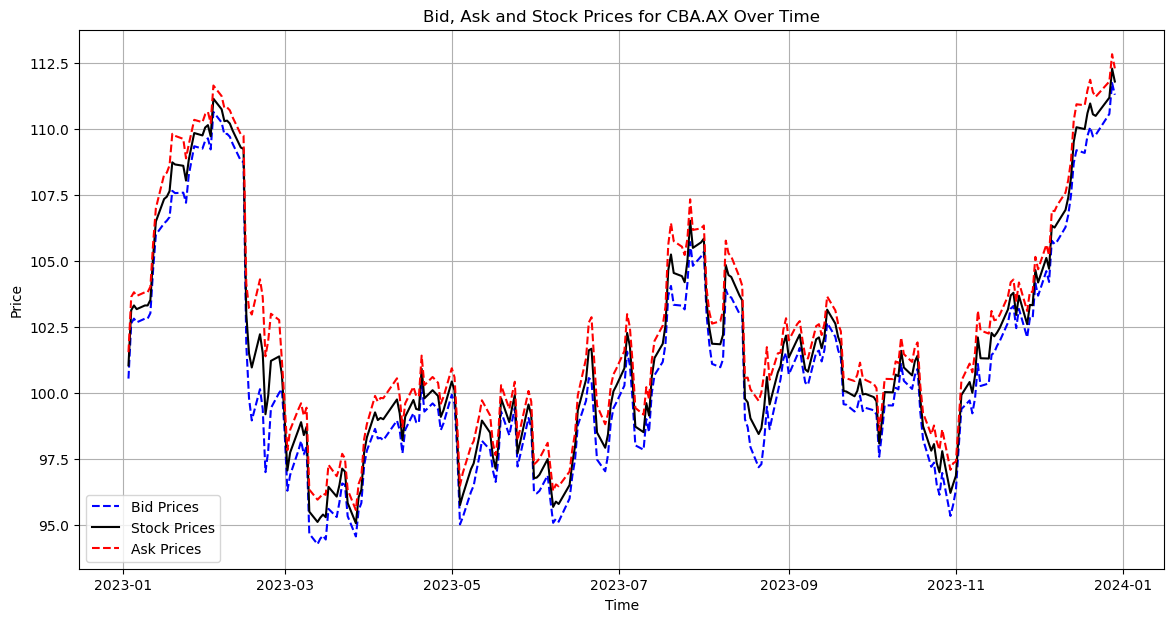

In [93]:
visualQuotes(historical_data,market_maker)


In [42]:
def visualize_capital_and_profit(algoTraders, historical_data):
    """
    Plot the cumulative profit and capital of multiple traders over the historical period.
    Input:
        algoTraders - A list of algorithmic trader instances.
        historical_data - The historical data used for backtesting, with timestamps.
    """
    timestamps = historical_data['Date']
    plt.figure(figsize=(14, 7))
    
    for trader in algoTraders:
        trade_history = trader.trade_history
        profits = []
        capital = []
        
        for timestamp in timestamps:
            # Extract relevant trades with error handling for missing keys
            relevant_trades = [
                trade for trade in trade_history
                if 'timestamp' in trade and trade['timestamp'] <= timestamp
            ]
            if relevant_trades:
                last_trade = relevant_trades[-1]
                profits.append(last_trade.get('profit', 0))
                capital.append(last_trade.get('capital', trader.capital))
            else:
                profits.append(0)  # Default to zero profit
                capital.append(trader.capital)  # Use initial capital

        # Plot the trader's data
        plt.plot(timestamps, profits, label=f"{trader.name} Profit", linestyle='--')
        plt.plot(timestamps, capital, label=f"{trader.name} Capital", linestyle='-')

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Cumulative Profit and Capital of Algorithmic Traders Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialisation

OrderBook: This component holds all the orders (buy/sell) in the market.

MatchingEngine: The engine matches buy and sell orders in the order book.

FixApplication: Represents the FIX protocol application used to communicate with other systems (such as exchanges). It connects with the matching engine for order routing.

In [52]:
order_book = OrderBook()
matching_engine = MatchingEngine(order_book)
fix_app = FixApplication(matching_engine)

# Prompt user for the stock ticker
ticker_symbol = input("Enter the stock ticker symbol you want to track: ").upper()

# Initialize the MarketDataFeed with the user-provided ticker symbol
market_data_feed = MarketDataFeed(symbol=ticker_symbol)
market_maker = MarketMaker(symbol=ticker_symbol, matching_engine=matching_engine,order_book=order_book)

# Start FIX server
fix_thread = threading.Thread(target=fix_app.start)
fix_thread.start()

# Start market data feed
feed_thread = threading.Thread(target=market_data_feed.start)
feed_thread.start()

# Start market maker
market_maker.start(market_data_feed)

Enter the stock ticker symbol you want to track (e.g., AAPL): CBA.AX


2025-01-04 22:22:01,762 - FIX server started. Waiting for connections...
2025-01-04 22:22:02,481 - Posted bid: 154.53 with quantity 52, ask: 155.53 with quantity 26



Order Book:
Bid Side:
  Order ID   Price  Quantity
0    79220  154.53        52

Ask Side:
  Order ID   Price  Quantity
0    63973  155.53        26


2025-01-04 22:22:32,765 - Best ask price: 155.53, Incoming buy order price: 154.53 with quantity 83
2025-01-04 22:22:32,766 - Best bid price: 154.53, Incoming sell order price: 155.53
2025-01-04 22:22:32,768 - Posted bid: 154.53 with quantity 83, ask: 155.53 with quantity 78



Order Book:
Bid Side:
  Order ID   Price  Quantity
0    79220  154.53        52
1    79138  154.53        83

Ask Side:
  Order ID   Price  Quantity
0    63973  155.53        26
1    69483  155.53        78


# Order Creation and Control (documentation, do not run)

In [ ]:
# Create an ask order
ask_order = Order(id='2', price=415, quantity=100, side='sell', type='limit', symbol='AAPL')
order_book.add_order(ask_order)

# Post a buy order that should match the ask
buy_order = Order(id='2', price=228.00, quantity=100, side='buy', type='limit', symbol='AAPL')
order_book.add_order(buy_order)
matching_engine.match_order(buy_order)

# Display the order book after matching
order_book.display_order_book()

In [ ]:
order1 = Order(id='1', price=100.0, quantity=10, side='buy', type='limit', symbol='AAPL')
order2 = Order(id='2', price=101.0, quantity=20, side='buy', type='limit', symbol='AAPL')
order3 = Order(id='3', price=102.0, quantity=15, side='sell', type='limit', symbol='AAPL')
order4 = Order(id='4', price=103.0, quantity=25, side='sell', type='limit', symbol='AAPL')

order_book.modify_order(order_id='2', new_quantity=30, new_price=100.5)
order_book.cancel_order(order_id='3')

# Liquidity controls

In [43]:
ticker_symbol='CBA.AX' # testing purposes

liquidity_provider = SyntheticLiquidityProvider(symbol=ticker_symbol, matching_engine=matching_engine, order_book=order_book, num_orders=10)
auto_inject_liquidity = liquidity_provider.generate_liquidity()
depth_liquidity = liquidity_provider.generate_depth_liquidity()


2024-12-30 17:29:50,423 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:50,424 - Synthetic liquidity added: sell order with quantity 38 at 155.08
2024-12-30 17:29:50,511 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:50,511 - Synthetic liquidity added: sell order with quantity 43 at 155.08
2024-12-30 17:29:50,599 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:50,600 - Synthetic liquidity added: sell order with quantity 87 at 155.08
2024-12-30 17:29:50,689 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:50,689 - Synthetic liquidity added: sell order with quantity 54 at 155.08
2024-12-30 17:29:50,757 - Best ask price: 155.08, Incoming buy order price: 155.08 with quantity 88
2024-12-30 17:29:50,759 - Executing buy order at price 155.08
2024-12-30 17:29:50,759 - Partially matched order 87531 with 52275 at price 155.08
2024-12-30 17:29:50,761 - Fully matched order 87531 wit

Order 35797 has been modified.
Order 35797 has been modified.
Order 87531 has been modified.
Order 92882 has been modified.


2024-12-30 17:29:50,966 - Executing sell order at price 155.08
2024-12-30 17:29:50,967 - Price level 155.08 already removed from order book
2024-12-30 17:29:50,968 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:50,968 - Synthetic liquidity added: sell order with quantity 95 at 155.08
2024-12-30 17:29:51,030 - Best bid price: 155.07, Incoming sell order price: 155.08
2024-12-30 17:29:51,031 - Synthetic liquidity added: sell order with quantity 46 at 155.08
2024-12-30 17:29:51,094 - Best ask price: 155.08, Incoming buy order price: 155.08 with quantity 60
2024-12-30 17:29:51,095 - Executing buy order at price 155.08
2024-12-30 17:29:51,095 - Fully matched order 50724 with 74647 at price 155.08
2024-12-30 17:29:51,096 - Best ask price: 155.08, Incoming buy order price: 155.08 with quantity 60
2024-12-30 17:29:51,096 - Executing buy order at price 155.08
2024-12-30 17:29:51,098 - Partially matched order 50724 with 47480 at price 155.08
2024-12-30 17:29:51,098 

2024-12-30 17:29:51,193 - Best ask price: 155.09, Incoming buy order price: 154.86 with quantity 738
2024-12-30 17:29:51,193 - Synthetic bid order added: 738 shares at 154.86
2024-12-30 17:29:51,194 - Best bid price: 155.08, Incoming sell order price: 155.3
2024-12-30 17:29:51,194 - Synthetic ask order added: 1766 shares at 155.3
2024-12-30 17:29:51,195 - Best ask price: 155.09, Incoming buy order price: 154.85 with quantity 665
2024-12-30 17:29:51,195 - Synthetic bid order added: 665 shares at 154.85
2024-12-30 17:29:51,195 - Best bid price: 155.08, Incoming sell order price: 155.31
2024-12-30 17:29:51,196 - Synthetic ask order added: 500 shares at 155.31
2024-12-30 17:29:51,196 - Best ask price: 155.09, Incoming buy order price: 154.84 with quantity 205
2024-12-30 17:29:51,197 - Synthetic bid order added: 205 shares at 154.84
2024-12-30 17:29:51,197 - Best bid price: 155.08, Incoming sell order price: 155.32
2024-12-30 17:29:51,197 - Synthetic ask order added: 1489 shares at 155.32
2

Order 74647 has been modified.


In [44]:
order_book.display_order_book()


Order Book:
Bid Side:
   Order ID   Price  Quantity
0     50724  155.08        60
1     86128  155.07      1143
2     21662  155.07      1370
3     31239  155.06       231
4     93413  155.06       593
..      ...     ...       ...
76    43458   95.40       100
77    37917   95.30       100
78    96367   95.28       100
79    41847   95.12       100
80    79202   95.07       100

[81 rows x 3 columns]

Ask Side:
   Order ID   Price  Quantity
0     45598  155.09      1094
1     34599  155.09       616
2     96723  155.10      1336
3     93294  155.10       797
4     81393  155.11      1842
5     13894  155.11       768
6     78268  155.12      1499
7     22592  155.12       140
8     46220  155.13       914
9     26655  155.13      1268
10    10692  155.14      1021
11    31457  155.14      1509
12    48434  155.15      1624
13    89157  155.15      1674
14    82942  155.16       196
15    78189  155.16       114
16    88759  155.17      1839
17    80567  155.17      1122
18    59892  

In [ ]:
liquidity_thread = threading.Thread(target=auto_inject_liquidity, args=(liquidity_provider, 5))  # Inject every 5 seconds
liquidity_thread.start()

# Trading Bot Controls

In [ ]:
# Initialize the traders
momentum_trader = MomentumTrader(symbol=ticker_symbol, matching_engine=matching_engine, order_book=order_book, interval=10)
ema_trader = EMABasedTrader(symbol=ticker_symbol, matching_engine=matching_engine, order_book=order_book, interval=30)
swing_trader = SwingTrader(symbol=ticker_symbol, matching_engine=matching_engine, order_book=order_book, interval=15)
# Collect all traders into a list
traders = [momentum_trader, ema_trader, swing_trader]

# Start each trader in its own thread
trader_threads = []
# Starts each trader in its own thread so they can run concurrently and make decisions based on real-time market data.
for trader in traders:
    thread = threading.Thread(target=trader.start, args=(market_data_feed,)) 
    thread.start()
    trader_threads.append(thread)

# Stop All

In [53]:
market_maker.stop()
market_data_feed.stop()
fix_app.stop()



2025-01-04 22:22:51,074 - FIX server stopped.
2025-01-04 22:22:51,075 - Server socket closed.


In [54]:
# Stop all traders
for trader in traders:
    trader.stop()

# Join all threads to ensure they have finished
for thread in trader_threads:
    thread.join()

NameError: name 'traders' is not defined